# Impact of fault zones on production - Karnes Trough

In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapash.explainer.smart_explainer import SmartExplainer
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import mean_absolute_error

sns.set(context="talk")
fig_dir = "figures/"

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = (
    pd.read_parquet("austin_chalk_ml_vars.parquet")
    .dropna(subset=["Fault length"])
    .assign(min_dist=lambda x: x.min_dist.fillna(2.6e3))[
        lambda x: x.start_date.dt.year >= 2010
    ]
)

[Text(0.5, 0, 'EUR / lateral in log scale')]

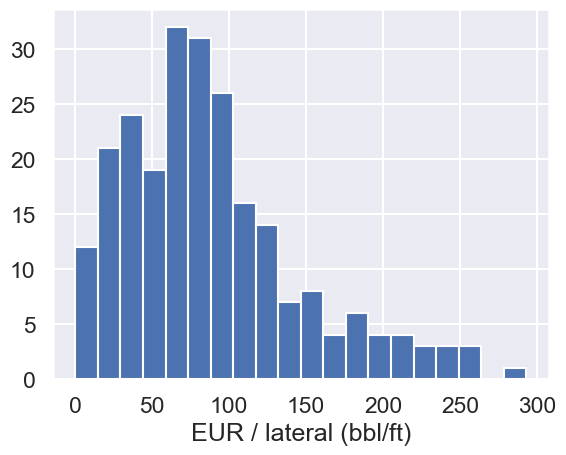

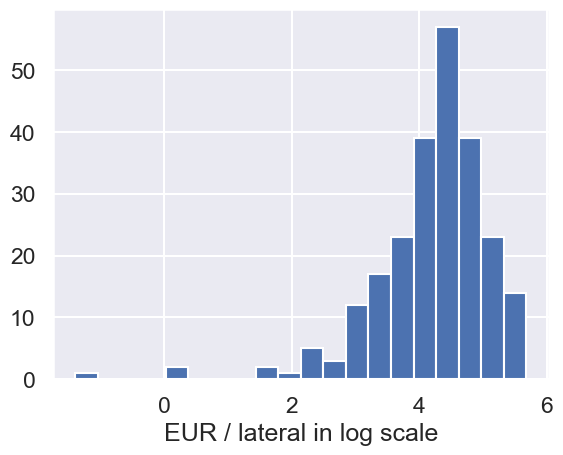

In [5]:
df.liquids_eur_length.hist(bins=20)
plt.gca().set(xlabel="EUR / lateral (bbl/ft)")
plt.figure()
df.liquids_eur_length.pipe(np.log).hist(bins=20)
plt.gca().set(xlabel="EUR / lateral in log scale")

,gravity,gor,length_lateral,min_dist,prop_per_length_c,fluid_per_length_c,stages_number,Distance to nearest fault,Fault length,bearing,sinuosity
count,227.000000,238.000000,238.000000,238.000000,228.000000,228.000000,209.000000,238.000000,238.000000,238.000000,238.000000
mean,43.716740,3.167110,4425.146849,936.328822,2312.049028,1932.210597,2.272727,2558.577225,32.700744,62.274368,1.005261
std,4.897795,3.511855,1668.886003,805.621455,1040.621487,859.797327,7.515194,2870.490886,130.985734,22.288737,0.009127
min,22.500000,0.000000,780.000000,72.924897,0.000000,0.000000,0.000000,0.000000,2.859000,30.282333,1.000000
25%,42.000000,1.817638,3274.250000,384.659369,2201.867720,1780.318350,0.000000,92.595139,9.381000,57.086368,1.001121
50%,43.400000,2.747053,4226.500000,592.834981,2795.509528,2243.238662,0.000000,1364.836404,12.511000,60.196167,1.002460
75%,44.700000,3.644497,5337.250000,1056.354540,2988.554345,2446.612583,0.000000,3926.895752,12.511000,71.467715,1.002515
max,66.300000,42.093683,9663.000000,2600.000000,3586.239397,3969.335826,45.000000,10454.435350,993.600000,237.397111,1.058196


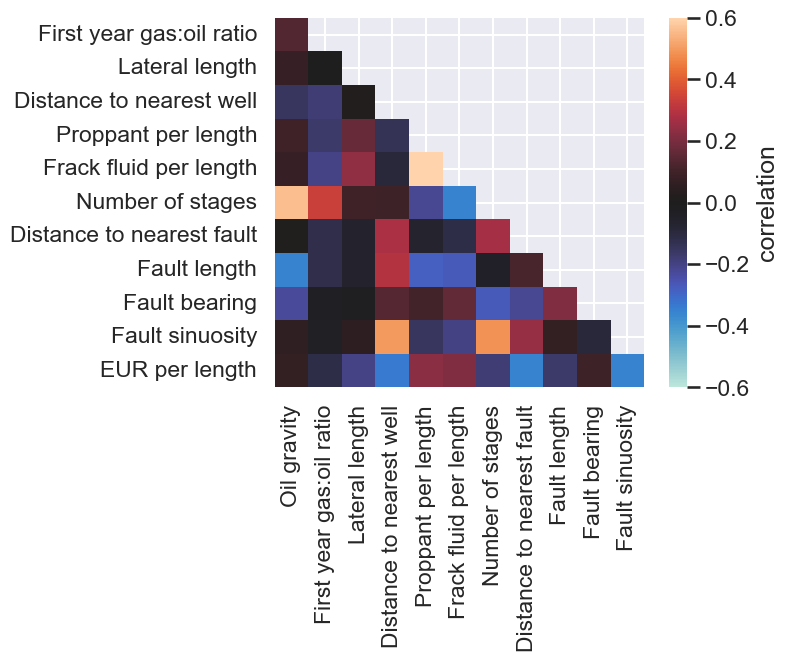

In [6]:
rename = {
    "gravity": "Oil gravity",
    "water_cut": "Water cut",
    "gor": "First year gas:oil ratio",
    "length_lateral": "Lateral length",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant per length",
    "fluid_per_length_c": "Frack fluid per length",
    "stages_number": "Number of stages",
    "Distance to nearest fault": "Distance to nearest fault",
    "Fault length": "Fault length",
    "bearing": "Fault bearing",
    "sinuosity": "Fault sinuosity",
}
X_cols = [
    "gravity",
    #'water_cut',
    "gor",
    "length_lateral",
    "min_dist",
    "prop_per_length_c",
    "fluid_per_length_c",
    "stages_number",
    "Distance to nearest fault",
    "Fault length",
    "bearing",
    "sinuosity",
]

correlations = (
    df[X_cols]
    .rename(columns=rename)
    .join(df.liquids_eur_length.rename("EUR per length"))
    .corr()
)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    correlations.iloc[1:, :-1],
    mask=mask[1:, :-1],
    square=True,
    cmap="icefire",
    vmin=-0.6,
    vmax=0.6,
    cbar_kws={"label": "correlation"},
)
df[X_cols].describe()

In [5]:
# import sweetviz as sv

# report = sv.analyze(
#     df[X_cols + ["liquids_eur_length"]],
#     target_feat="liquids_eur_length",
#     pairwise_analysis="on",
# )
# report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
y = df.liquids_eur_length.pipe(np.log)
X = df.loc[y.index, X_cols].fillna(-1).rename(columns=rename)

X[X == -1].sum()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

baseline_mae = mean_absolute_error(y_train, np.ones(y_train.shape) * np.mean(y_train))
print(f"Baseline MAE is {baseline_mae:.2f}")

Baseline MAE is 0.63


In [9]:
# params = {
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'eta': 0.1,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     'objective': 'reg:squarederror',
#     'eval_metric': 'mae'
# }
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=1000,
#     seed=42,
#     nfold=5,
#     metrics=['mae'],
#     early_stopping_rounds=20
# )

In [11]:
def xgb_cv(max_depth, gamma, eta, min_child_weight, subsample, colsample_bytree):
    paramt = {
        "booster": "gbtree",
        "max_depth": int(max_depth),
        "gamma": gamma,
        "objective": "reg:squarederror",
        "nthread": 4,
        "eta": eta,
        "eval_metric": "rmse",
        "subsample": max(min(subsample, 1), 0),
        "colsample_bytree": max(min(colsample_bytree, 1), 0),
        "min_child_weight": min_child_weight,
        "seed": 1001,
        "tree_method": "hist",
        "gpu_id": 0,
    }

    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=342)
    xgbc = xgb.cv(
        paramt,
        dtrain,
        num_boost_round=2000,
        folds=rkf,
        early_stopping_rounds=100,
        metrics="rmse",
        show_stdv=True,
    )

    val_score = xgbc["test-rmse-mean"].iloc[-1]
    train_score = xgbc["train-rmse-mean"].iloc[-1]
    print(
        f" Stopped after {len(xgbc)} iterations with train = {train_score:.2f} val = {val_score:.2f}"
        f" ( diff = {train_score - val_score:.2f} )"
    )

    return -val_score

In [12]:
xgb_bo = BayesianOptimization(
    xgb_cv,
    {
        "max_depth": (2, 12),  # tree splits
        "gamma": (0.001, 10.0),  # regularization
        "eta": (0.005, 0.1),  # learning rate
        "min_child_weight": (0, 20),  # wells per leaf
        "subsample": (0.4, 1.0),  # training sample
        "colsample_bytree": (0.4, 1.0),  # columns sample
    },
)

In [14]:
xgb_bo.maximize(init_points=500, n_iter=80)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:02] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1207 iterations with train = 0.65 val = 0.75 ( diff = -0.09 )
| 1         | -0.7462   | 0.6853    | 0.04612   | 6.895     | 6.145     | 12.68     | 0.7215    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 241 iterations with train = 0.72 val = 0.79 ( diff = -0.07 )
| 2         | -0.7857   | 0.788     | 0.0585    | 9.963     | 8.933     | 15.43     | 0.9481    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 386 iterations with train = 0.63 val = 0.75 ( diff = -0.12 )
| 3         | -0.7506   | 0.6428    | 0.06483   | 6.598     | 4.2       | 7.301     | 0.6844    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.54 val = 0.70 ( diff = -0.16 )
| 4         | -0.6965   | 0.8605    | 0.03944   | 1.52      | 4.347     | 8.516     | 0.5285    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 753 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 5         | -0.739    | 0.869     | 0.04762   | 5.138     | 6.605     | 18.12     | 0.6591    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 408 iterations with train = 0.51 val = 0.74 ( diff = -0.23 )
| 6         | -0.7402   | 0.8571    | 0.04378   | 2.526     | 9.767     | 1.453     | 0.9831    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 998 iterations with train = 0.62 val = 0.74 ( diff = -0.12 )
| 7         | -0.7428   | 0.9665    | 0.04989   | 5.587     | 7.528     | 9.847     | 0.8432    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 92 iterations with train = 0.59 val = 0.71 ( diff = -0.12 )
| 8         | -0.7117   | 0.4387    | 0.07058   | 1.803     | 5.907     | 18.41     | 0.8686    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 981 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 9         | -0.7608   | 0.6241    | 0.04527   | 7.987     | 10.68     | 6.173     | 0.7654    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 117 iterations with train = 0.53 val = 0.74 ( diff = -0.21 )
| 10        | -0.7379   | 0.9599    | 0.08477   | 2.822     | 11.33     | 2.67      | 0.9826    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1209 iterations with train = 0.66 val = 0.77 ( diff = -0.11 )
| 11        | -0.7711   | 0.9031    | 0.01525   | 8.574     | 3.123     | 5.746     | 0.8181    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1170 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 12        | -0.7463   | 0.4708    | 0.01123   | 3.45      | 8.598     | 19.24     | 0.563     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 13        | -0.7599   | 0.7178    | 0.09971   | 9.932     | 4.961     | 12.24     | 0.4359    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 14        | -0.7351   | 0.8702    | 0.0497    | 3.578     | 10.78     | 17.04     | 0.949     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 846 iterations with train = 0.64 val = 0.74 ( diff = -0.11 )
| 15        | -0.7433   | 0.8848    | 0.02289   | 5.266     | 7.546     | 12.59     | 0.8498    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 120 iterations with train = 0.53 val = 0.70 ( diff = -0.17 )
| 16        | -0.7005   | 0.4975    | 0.048     | 0.5457    | 2.474     | 16.6      | 0.8436    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.68 val = 0.75 ( diff = -0.06 )
| 17        | -0.7488   | 0.8927    | 0.09503   | 7.797     | 10.15     | 13.17     | 0.4417    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 18        | -0.7489   | 0.6508    | 0.06406   | 6.43      | 6.217     | 18.81     | 0.8505    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.61 val = 0.73 ( diff = -0.12 )
| 19        | -0.7341   | 0.4252    | 0.0647    | 4.134     | 5.298     | 10.97     | 0.823     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 620 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 20        | -0.7458   | 0.663     | 0.02313   | 6.979     | 10.16     | 6.898     | 0.4426    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 178 iterations with train = 0.64 val = 0.76 ( diff = -0.13 )
| 21        | -0.765    | 0.4013    | 0.06793   | 6.748     | 5.983     | 1.896     | 0.9658    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:08:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 48 iterations with train = 0.58 val = 0.74 ( diff = -0.17 )
| 22        | -0.744    | 0.6234    | 0.09047   | 4.062     | 2.528     | 1.463     | 0.6654    |
 Stopped after 1035 iterations with train = 0.62 val = 0.76 ( diff = -0.14 )
| 23        | -0.7584   | 0.7022    | 0.01895   | 6.799     | 11.69     | 0.2497    | 0.7445    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 361 iterations with train = 0.63 val = 0.75 ( diff = -0.11 )
| 24        | -0.7483   | 0.6874    | 0.06102   | 7.833     | 11.38     | 0.2635    | 0.4023    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 551 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 25        | -0.7268   | 0.536     | 0.08184   | 4.064     | 10.79     | 14.65     | 0.7832    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.62 val = 0.72 ( diff = -0.09 )
| 26        | -0.7177   | 0.7971    | 0.02759   | 2.99      | 8.874     | 13.83     | 0.5952    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 199 iterations with train = 0.64 val = 0.73 ( diff = -0.09 )
| 27        | -0.7341   | 0.5572    | 0.04185   | 5.518     | 11.81     | 5.285     | 0.4023    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.63 val = 0.74 ( diff = -0.11 )
| 28        | -0.7446   | 0.5233    | 0.09402   | 5.254     | 11.23     | 10.05     | 0.8594    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 522 iterations with train = 0.68 val = 0.77 ( diff = -0.09 )
| 29        | -0.7679   | 0.8955    | 0.09875   | 7.035     | 9.931     | 12.8      | 0.9933    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 30        | -0.7622   | 0.6136    | 0.06908   | 7.967     | 6.594     | 3.383     | 0.9004    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 73 iterations with train = 0.33 val = 0.71 ( diff = -0.37 )
| 31        | -0.7052   | 0.6164    | 0.03029   | 0.08619   | 5.077     | 2.412     | 0.9672    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 32        | -0.7267   | 0.886     | 0.07496   | 4.851     | 5.585     | 10.37     | 0.7332    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 216 iterations with train = 0.56 val = 0.72 ( diff = -0.16 )
| 33        | -0.7215   | 0.4479    | 0.08399   | 2.244     | 8.894     | 9.463     | 0.9673    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 972 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 34        | -0.7609   | 0.942     | 0.053     | 9.521     | 11.89     | 15.82     | 0.7661    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 373 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 35        | -0.7196   | 0.4195    | 0.0459    | 2.835     | 4.995     | 12.13     | 0.8496    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.72 val = 0.78 ( diff = -0.06 )
| 36        | -0.7763   | 0.4203    | 0.008851  | 8.456     | 8.6       | 18.13     | 0.9592    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.68 val = 0.78 ( diff = -0.09 )
| 37        | -0.7777   | 0.8439    | 0.04415   | 9.982     | 2.15      | 8.668     | 0.8023    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 150 iterations with train = 0.42 val = 0.68 ( diff = -0.26 )
| 38        | -0.6821   | 0.4756    | 0.02139   | 0.1744    | 6.344     | 6.975     | 0.7455    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1275 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 39        | -0.7593   | 0.4727    | 0.03617   | 8.677     | 2.173     | 8.448     | 0.6598    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 199 iterations with train = 0.68 val = 0.75 ( diff = -0.08 )
| 40        | -0.7527   | 0.9494    | 0.07783   | 3.974     | 7.35      | 15.78     | 0.405     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.66 val = 0.75 ( diff = -0.09 )
| 41        | -0.7458   | 0.6375    | 0.05899   | 6.062     | 7.001     | 12.21     | 0.6869    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 42        | -0.7625   | 0.4324    | 0.08165   | 8.762     | 4.15      | 6.42      | 0.7477    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.60 val = 0.73 ( diff = -0.13 )
| 43        | -0.7294   | 0.5171    | 0.006269  | 4.036     | 9.211     | 6.247     | 0.6148    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 177 iterations with train = 0.62 val = 0.76 ( diff = -0.14 )
| 44        | -0.7569   | 0.8838    | 0.09374   | 5.391     | 2.407     | 6.931     | 0.9279    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 45        | -0.747    | 0.5837    | 0.04673   | 7.365     | 7.802     | 8.141     | 0.5234    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:09:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 42 iterations with train = 0.46 val = 0.71 ( diff = -0.25 )
| 46        | -0.7119   | 0.4184    | 0.07098   | 1.369     | 6.223     | 0.5974    | 0.7296    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.60 val = 0.71 ( diff = -0.11 )
| 47        | -0.7105   | 0.4136    | 0.03395   | 2.507     | 11.82     | 7.387     | 0.403     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 350 iterations with train = 0.46 val = 0.72 ( diff = -0.26 )
| 48        | -0.7223   | 0.8793    | 0.01985   | 1.694     | 4.288     | 2.315     | 0.9261    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 466 iterations with train = 0.69 val = 0.75 ( diff = -0.07 )
| 49        | -0.7535   | 0.896     | 0.08589   | 4.768     | 4.157     | 19.9      | 0.5216    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 67 iterations with train = 0.45 val = 0.69 ( diff = -0.23 )
| 50        | -0.6859   | 0.914     | 0.04573   | 0.289     | 6.272     | 7.981     | 0.7021    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 49 iterations with train = 0.42 val = 0.70 ( diff = -0.29 )
| 51        | -0.7048   | 0.943     | 0.06325   | 0.6147    | 3.877     | 5.736     | 0.8908    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 392 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 52        | -0.74     | 0.9269    | 0.08325   | 6.389     | 11.29     | 13.85     | 0.4385    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.65 val = 0.74 ( diff = -0.09 )
| 53        | -0.738    | 0.981     | 0.04592   | 5.978     | 5.731     | 10.73     | 0.6231    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 168 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 54        | -0.7089   | 0.69      | 0.07284   | 2.337     | 10.33     | 7.768     | 0.5701    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 198 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 55        | -0.7403   | 0.9769    | 0.06149   | 6.044     | 4.384     | 12.11     | 0.5325    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.71 val = 0.77 ( diff = -0.06 )
| 56        | -0.7694   | 0.9234    | 0.084     | 9.446     | 6.557     | 17.72     | 0.5519    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.60 val = 0.74 ( diff = -0.14 )
| 57        | -0.739    | 0.9576    | 0.09173   | 5.589     | 6.645     | 3.904     | 0.7417    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 58        | -0.7613   | 0.8       | 0.0554    | 7.526     | 7.806     | 9.355     | 0.8387    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.65 val = 0.76 ( diff = -0.12 )
| 59        | -0.7645   | 0.8952    | 0.08171   | 8.962     | 7.934     | 2.809     | 0.8021    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 148 iterations with train = 0.51 val = 0.69 ( diff = -0.19 )
| 60        | -0.6946   | 0.7799    | 0.0268    | 0.8592    | 10.85     | 12.09     | 0.8641    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 61        | -0.7501   | 0.4444    | 0.08597   | 7.488     | 11.49     | 11.8      | 0.4733    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.71 val = 0.77 ( diff = -0.06 )
| 62        | -0.7657   | 0.7102    | 0.01481   | 9.617     | 2.608     | 15.55     | 0.659     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1102 iterations with train = 0.67 val = 0.78 ( diff = -0.11 )
| 63        | -0.7825   | 0.8137    | 0.04268   | 7.844     | 9.962     | 6.022     | 0.9793    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 733 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 64        | -0.7627   | 0.5061    | 0.09647   | 9.515     | 6.717     | 15.06     | 0.5548    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 466 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 65        | -0.7409   | 0.4628    | 0.06227   | 4.809     | 9.263     | 12.26     | 0.4009    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 981 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 66        | -0.7666   | 0.6293    | 0.02676   | 9.424     | 5.016     | 6.867     | 0.6108    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 67        | -0.7422   | 0.9285    | 0.09893   | 6.397     | 5.645     | 17.58     | 0.7132    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 452 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 68        | -0.7592   | 0.6212    | 0.09008   | 9.443     | 2.91      | 14.47     | 0.6977    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1221 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 69        | -0.7581   | 0.8252    | 0.02426   | 9.751     | 9.976     | 11.02     | 0.5604    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1153 iterations with train = 0.59 val = 0.75 ( diff = -0.16 )
| 70        | -0.7508   | 0.9208    | 0.01379   | 4.023     | 11.3      | 6.884     | 0.9617    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 502 iterations with train = 0.60 val = 0.74 ( diff = -0.13 )
| 71        | -0.7357   | 0.5112    | 0.07578   | 5.769     | 7.605     | 2.132     | 0.4825    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:10:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 390 iterations with train = 0.63 val = 0.77 ( diff = -0.14 )
| 72        | -0.7683   | 0.9876    | 0.0909    | 7.302     | 7.742     | 1.626     | 0.8643    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 551 iterations with train = 0.62 val = 0.72 ( diff = -0.10 )
| 73        | -0.7191   | 0.9482    | 0.0729    | 2.99      | 10.76     | 19.22     | 0.8978    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 74        | -0.7194   | 0.9328    | 0.08446   | 2.953     | 3.053     | 14.63     | 0.8264    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 75        | -0.7423   | 0.8562    | 0.0601    | 6.206     | 11.52     | 14.81     | 0.713     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.61 val = 0.74 ( diff = -0.13 )
| 76        | -0.7381   | 0.8172    | 0.06935   | 5.095     | 9.617     | 8.537     | 0.8044    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.66 val = 0.73 ( diff = -0.08 )
| 77        | -0.734    | 0.6552    | 0.05921   | 3.697     | 5.943     | 14.29     | 0.478     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 28 iterations with train = 0.40 val = 0.68 ( diff = -0.28 )
| 78        | -0.6787   | 0.5026    | 0.09879   | 0.1892    | 11.12     | 5.548     | 0.8142    |
 Stopped after 1206 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 79        | -0.764    | 0.9149    | 0.01603   | 8.014     | 8.132     | 19.48     | 0.8118    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 697 iterations with train = 0.69 val = 0.78 ( diff = -0.08 )
| 80        | -0.7759   | 0.6752    | 0.05237   | 9.52      | 4.426     | 10.02     | 0.9024    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 252 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 81        | -0.709    | 0.82      | 0.03096   | 2.334     | 3.195     | 10.96     | 0.7846    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 55 iterations with train = 0.49 val = 0.69 ( diff = -0.20 )
| 82        | -0.6871   | 0.8118    | 0.08294   | 0.5795    | 9.316     | 13.49     | 0.8305    |
 Stopped after 193 iterations with train = 0.53 val = 0.70 ( diff = -0.17 )
| 83        | -0.7049   | 0.641     | 0.04571   | 2.354     | 11.93     | 4.52      | 0.5386    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 202 iterations with train = 0.48 val = 0.74 ( diff = -0.26 )
| 84        | -0.7378   | 0.6812    | 0.09766   | 2.172     | 11.77     | 0.2643    | 0.9315    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 989 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 85        | -0.758    | 0.5834    | 0.02761   | 8.852     | 11.83     | 3.96      | 0.7314    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 55 iterations with train = 0.48 val = 0.69 ( diff = -0.21 )
| 86        | -0.69     | 0.8233    | 0.08711   | 0.776     | 10.27     | 10.54     | 0.7416    |
 Stopped after 198 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 87        | -0.7142   | 0.5026    | 0.04849   | 3.048     | 4.406     | 3.405     | 0.6102    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 388 iterations with train = 0.70 val = 0.77 ( diff = -0.07 )
| 88        | -0.7673   | 0.8985    | 0.0786    | 8.829     | 6.791     | 15.1      | 0.8997    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 89        | -0.7271   | 0.7157    | 0.04305   | 3.9       | 6.05      | 12.1      | 0.646     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.66 val = 0.74 ( diff = -0.07 )
| 90        | -0.7356   | 0.6783    | 0.05413   | 5.751     | 6.41      | 13.53     | 0.5994    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 221 iterations with train = 0.58 val = 0.73 ( diff = -0.15 )
| 91        | -0.7334   | 0.6478    | 0.05344   | 4.409     | 3.888     | 4.879     | 0.7151    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1356 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 92        | -0.7342   | 0.6465    | 0.01245   | 3.4       | 9.219     | 17.96     | 0.9689    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 179 iterations with train = 0.57 val = 0.71 ( diff = -0.14 )
| 93        | -0.7094   | 0.9517    | 0.08664   | 2.268     | 3.277     | 14.71     | 0.7739    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 674 iterations with train = 0.68 val = 0.79 ( diff = -0.10 )
| 94        | -0.785    | 0.4614    | 0.02101   | 7.616     | 7.588     | 7.219     | 0.9906    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 95        | -0.7506   | 0.6149    | 0.02441   | 6.766     | 7.942     | 17.31     | 0.7526    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 96        | -0.7404   | 0.4738    | 0.01703   | 5.423     | 2.072     | 11.35     | 0.7662    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 523 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 97        | -0.741    | 0.8798    | 0.09068   | 6.906     | 5.381     | 12.8      | 0.42      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.58 val = 0.71 ( diff = -0.13 )
| 98        | -0.7077   | 0.8256    | 0.09661   | 2.296     | 11.17     | 15.88     | 0.7819    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:11:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 972 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 99        | -0.7584   | 0.8489    | 0.06869   | 8.592     | 5.078     | 4.067     | 0.7966    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.60 val = 0.72 ( diff = -0.13 )
| 100       | -0.7247   | 0.523     | 0.02126   | 3.747     | 2.2       | 7.509     | 0.4712    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 306 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 101       | -0.7276   | 0.7442    | 0.09457   | 4.88      | 6.889     | 11.87     | 0.5711    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 199 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 102       | -0.7608   | 0.9762    | 0.07955   | 5.192     | 5.643     | 16.28     | 0.432     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 588 iterations with train = 0.62 val = 0.75 ( diff = -0.13 )
| 103       | -0.7526   | 0.6795    | 0.09244   | 7.775     | 8.325     | 0.6215    | 0.5927    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 524 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 104       | -0.7331   | 0.5103    | 0.05937   | 3.516     | 7.588     | 12.63     | 0.4246    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.61 val = 0.74 ( diff = -0.13 )
| 105       | -0.735    | 0.8767    | 0.01945   | 5.537     | 10.07     | 3.749     | 0.4997    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 588 iterations with train = 0.65 val = 0.75 ( diff = -0.11 )
| 106       | -0.7518   | 0.7763    | 0.05151   | 9.057     | 3.922     | 3.957     | 0.5498    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.70 val = 0.80 ( diff = -0.10 )
| 107       | -0.7957   | 0.9459    | 0.00735   | 9.346     | 4.242     | 7.431     | 0.9635    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 741 iterations with train = 0.71 val = 0.78 ( diff = -0.08 )
| 108       | -0.7838   | 0.9425    | 0.03066   | 8.441     | 9.369     | 14.96     | 0.9877    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 143 iterations with train = 0.49 val = 0.70 ( diff = -0.20 )
| 109       | -0.6978   | 0.5319    | 0.05574   | 0.8943    | 11.2      | 11.76     | 0.8538    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 548 iterations with train = 0.70 val = 0.78 ( diff = -0.08 )
| 110       | -0.7812   | 0.4301    | 0.08996   | 9.885     | 7.069     | 9.678     | 0.9329    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.61 val = 0.73 ( diff = -0.12 )
| 111       | -0.7276   | 0.7208    | 0.08782   | 4.286     | 9.139     | 10.32     | 0.696     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 296 iterations with train = 0.70 val = 0.79 ( diff = -0.09 )
| 112       | -0.7898   | 0.9214    | 0.07603   | 9.197     | 11.13     | 10.08     | 0.9868    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 255 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 113       | -0.7339   | 0.5364    | 0.06191   | 4.642     | 7.524     | 10.56     | 0.6796    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 158 iterations with train = 0.66 val = 0.74 ( diff = -0.07 )
| 114       | -0.7379   | 0.7186    | 0.08921   | 4.345     | 10.3      | 15.98     | 0.5216    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.66 val = 0.75 ( diff = -0.09 )
| 115       | -0.7535   | 0.6399    | 0.08671   | 9.779     | 8.552     | 2.065     | 0.4383    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.59 val = 0.74 ( diff = -0.15 )
| 116       | -0.742    | 0.7609    | 0.09264   | 4.504     | 4.881     | 6.386     | 0.8659    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.63 val = 0.76 ( diff = -0.12 )
| 117       | -0.7576   | 0.7622    | 0.005882  | 7.48      | 7.005     | 1.273     | 0.6011    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 383 iterations with train = 0.69 val = 0.77 ( diff = -0.08 )
| 118       | -0.7667   | 0.5591    | 0.09493   | 6.931     | 6.289     | 18.78     | 0.9731    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 158 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 119       | -0.7442   | 0.6592    | 0.08312   | 2.476     | 11.61     | 18.75     | 0.4855    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 153 iterations with train = 0.59 val = 0.71 ( diff = -0.12 )
| 120       | -0.7092   | 0.825     | 0.05527   | 2.08      | 9.361     | 18.95     | 0.807     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 121       | -0.7735   | 0.8384    | 0.05115   | 9.798     | 3.897     | 2.139     | 0.8885    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 122       | -0.7394   | 0.9383    | 0.04548   | 6.079     | 8.971     | 11.63     | 0.5727    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 123       | -0.7126   | 0.7018    | 0.02389   | 2.82      | 4.094     | 4.124     | 0.5949    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 248 iterations with train = 0.45 val = 0.69 ( diff = -0.24 )
| 124       | -0.6903   | 0.7057    | 0.03198   | 0.0401    | 4.423     | 18.17     | 0.8291    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 261 iterations with train = 0.52 val = 0.72 ( diff = -0.21 )
| 125       | -0.7223   | 0.693     | 0.0932    | 2.32      | 5.941     | 5.704     | 0.9127    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:12:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 316 iterations with train = 0.63 val = 0.74 ( diff = -0.11 )
| 126       | -0.7377   | 0.6023    | 0.03172   | 4.137     | 8.925     | 13.16     | 0.9078    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 241 iterations with train = 0.71 val = 0.78 ( diff = -0.07 )
| 127       | -0.7776   | 0.7515    | 0.08874   | 8.064     | 10.37     | 17.89     | 0.9943    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 128       | -0.7561   | 0.9269    | 0.02392   | 7.568     | 4.389     | 18.1      | 0.7971    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.65 val = 0.74 ( diff = -0.09 )
| 129       | -0.7389   | 0.5819    | 0.00534   | 4.702     | 11.58     | 14.6      | 0.7696    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1077 iterations with train = 0.73 val = 0.78 ( diff = -0.05 )
| 130       | -0.7785   | 0.8728    | 0.03019   | 8.198     | 5.148     | 19.85     | 0.5312    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 131       | -0.728    | 0.5452    | 0.05243   | 4.164     | 2.682     | 13.47     | 0.786     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 430 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 132       | -0.7529   | 0.9146    | 0.09352   | 4.931     | 3.264     | 18.19     | 0.504     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 733 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 133       | -0.7542   | 0.5005    | 0.09143   | 6.948     | 5.251     | 18.99     | 0.6005    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 28 iterations with train = 0.46 val = 0.70 ( diff = -0.23 )
| 134       | -0.6964   | 0.9311    | 0.07527   | 0.6716    | 9.828     | 3.91      | 0.6574    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 309 iterations with train = 0.58 val = 0.72 ( diff = -0.14 )
| 135       | -0.7162   | 0.8283    | 0.09962   | 3.312     | 7.998     | 10.33     | 0.8279    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 309 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 136       | -0.7512   | 0.8701    | 0.08528   | 6.536     | 7.635     | 19.47     | 0.647     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 879 iterations with train = 0.52 val = 0.72 ( diff = -0.19 )
| 137       | -0.7179   | 0.5864    | 0.01263   | 1.934     | 7.122     | 7.596     | 0.941     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 242 iterations with train = 0.47 val = 0.70 ( diff = -0.23 )
| 138       | -0.7015   | 0.9258    | 0.01467   | 0.9805    | 6.952     | 7.664     | 0.8434    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 744 iterations with train = 0.70 val = 0.77 ( diff = -0.07 )
| 139       | -0.7711   | 0.4951    | 0.09909   | 9.036     | 2.451     | 16.5      | 0.9273    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 753 iterations with train = 0.64 val = 0.76 ( diff = -0.11 )
| 140       | -0.7562   | 0.8636    | 0.05249   | 7.259     | 5.203     | 7.569     | 0.7461    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.57 val = 0.73 ( diff = -0.15 )
| 141       | -0.7258   | 0.6962    | 0.09264   | 3.805     | 4.353     | 6.574     | 0.6884    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 55 iterations with train = 0.45 val = 0.69 ( diff = -0.24 )
| 142       | -0.6911   | 0.5006    | 0.08701   | 0.2891    | 10.24     | 7.616     | 0.59      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.65 val = 0.74 ( diff = -0.08 )
| 143       | -0.7351   | 0.6348    | 0.02109   | 4.54      | 7.711     | 16.51     | 0.68      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 218 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 144       | -0.7646   | 0.4171    | 0.06984   | 8.096     | 11.33     | 13.73     | 0.8533    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 219 iterations with train = 0.57 val = 0.74 ( diff = -0.17 )
| 145       | -0.7362   | 0.688     | 0.05733   | 3.565     | 10.96     | 4.893     | 0.9493    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 884 iterations with train = 0.66 val = 0.77 ( diff = -0.11 )
| 146       | -0.7731   | 0.6646    | 0.03423   | 7.536     | 11.51     | 8.184     | 0.9278    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 248 iterations with train = 0.50 val = 0.70 ( diff = -0.20 )
| 147       | -0.6962   | 0.8624    | 0.04286   | 0.7811    | 8.949     | 17.04     | 0.7608    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 879 iterations with train = 0.55 val = 0.73 ( diff = -0.19 )
| 148       | -0.7339   | 0.467     | 0.007948  | 2.963     | 10.18     | 2.714     | 0.965     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:13:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1385 iterations with train = 0.60 val = 0.74 ( diff = -0.13 )
| 149       | -0.7351   | 0.8054    | 0.006621  | 3.885     | 10.18     | 9.723     | 0.8406    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.



 Stopped after 2000 iterations with train = 0.73 val = 0.80 ( diff = -0.07 )
| 150       | -0.7968   | 0.9225    | 0.00706   | 9.993     | 9.344     | 13.54     | 0.9835    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.71 val = 0.76 ( diff = -0.06 )
| 151       | -0.7639   | 0.4929    | 0.08228   | 9.546     | 2.514     | 14.34     | 0.455     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.59 val = 0.71 ( diff = -0.12 )
| 152       | -0.7133   | 0.7491    | 0.05139   | 1.881     | 9.875     | 19.31     | 0.8064    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 45 iterations with train = 0.45 val = 0.72 ( diff = -0.27 )
| 153       | -0.7196   | 0.9636    | 0.04524   | 1.151     | 11.35     | 1.348     | 0.7754    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 463 iterations with train = 0.58 val = 0.73 ( diff = -0.15 )
| 154       | -0.7279   | 0.8803    | 0.09288   | 4.007     | 2.389     | 8.466     | 0.8146    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 48 iterations with train = 0.65 val = 0.77 ( diff = -0.11 )
| 155       | -0.7663   | 0.4794    | 0.0668    | 7.506     | 10.13     | 0.51      | 0.8478    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1077 iterations with train = 0.67 val = 0.74 ( diff = -0.08 )
| 156       | -0.7444   | 0.9697    | 0.0638    | 6.734     | 9.01      | 16.97     | 0.8579    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 759 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 157       | -0.7072   | 0.5192    | 0.009994  | 2.251     | 8.631     | 5.007     | 0.4685    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 752 iterations with train = 0.66 val = 0.77 ( diff = -0.11 )
| 158       | -0.7696   | 0.8173    | 0.09897   | 9.429     | 11.48     | 2.324     | 0.9363    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 274 iterations with train = 0.57 val = 0.72 ( diff = -0.15 )
| 159       | -0.7165   | 0.6335    | 0.0289    | 2.604     | 7.515     | 7.86      | 0.5964    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 821 iterations with train = 0.60 val = 0.73 ( diff = -0.13 )
| 160       | -0.7289   | 0.6463    | 0.01784   | 2.847     | 11.14     | 12.71     | 0.9794    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 182 iterations with train = 0.61 val = 0.71 ( diff = -0.11 )
| 161       | -0.7133   | 0.761     | 0.05999   | 2.324     | 2.693     | 18.49     | 0.722     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 297 iterations with train = 0.62 val = 0.74 ( diff = -0.11 )
| 162       | -0.7365   | 0.9298    | 0.02302   | 0.1128    | 7.93      | 18.55     | 0.4864    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 163       | -0.7572   | 0.433     | 0.03865   | 7.899     | 3.432     | 12.24     | 0.795     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 741 iterations with train = 0.69 val = 0.78 ( diff = -0.09 )
| 164       | -0.7799   | 0.4201    | 0.09089   | 9.182     | 3.743     | 9.777     | 0.9597    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 588 iterations with train = 0.69 val = 0.76 ( diff = -0.06 )
| 165       | -0.7573   | 0.6826    | 0.06794   | 5.822     | 9.192     | 19.09     | 0.5638    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 279 iterations with train = 0.57 val = 0.72 ( diff = -0.15 )
| 166       | -0.715    | 0.7662    | 0.03572   | 2.73      | 5.615     | 7.007     | 0.5715    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 698 iterations with train = 0.44 val = 0.70 ( diff = -0.25 )
| 167       | -0.6987   | 0.854     | 0.006132  | 0.7768    | 8.446     | 7.723     | 0.8067    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 744 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 168       | -0.7636   | 0.5595    | 0.07231   | 7.731     | 7.088     | 14.64     | 0.9249    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:14:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 87 iterations with train = 0.56 val = 0.70 ( diff = -0.14 )
| 169       | -0.7029   | 0.6564    | 0.0724    | 1.084     | 3.331     | 12.54     | 0.5148    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 170       | -0.7635   | 0.8223    | 0.007315  | 8.999     | 6.788     | 5.823     | 0.6217    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 201 iterations with train = 0.59 val = 0.71 ( diff = -0.12 )
| 171       | -0.7107   | 0.5807    | 0.03444   | 2.049     | 7.538     | 15.08     | 0.7494    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 750 iterations with train = 0.71 val = 0.77 ( diff = -0.06 )
| 172       | -0.7673   | 0.6701    | 0.06977   | 8.14      | 8.327     | 19.31     | 0.9437    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 516 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 173       | -0.7358   | 0.5614    | 0.0392    | 5.721     | 6.34      | 12.56     | 0.5321    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 519 iterations with train = 0.69 val = 0.79 ( diff = -0.10 )
| 174       | -0.7917   | 0.4577    | 0.05987   | 9.25      | 4.01      | 1.741     | 0.9987    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 763 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 175       | -0.7486   | 0.6513    | 0.03203   | 6.77      | 3.553     | 9.99      | 0.7334    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 177 iterations with train = 0.68 val = 0.79 ( diff = -0.11 )
| 176       | -0.7894   | 0.6695    | 0.05341   | 7.917     | 5.093     | 7.094     | 0.9756    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 221 iterations with train = 0.62 val = 0.76 ( diff = -0.13 )
| 177       | -0.7569   | 0.8621    | 0.06032   | 6.624     | 9.18      | 2.763     | 0.7939    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 178       | -0.747    | 0.528     | 0.05165   | 5.286     | 6.482     | 14.23     | 0.9347    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 267 iterations with train = 0.67 val = 0.77 ( diff = -0.11 )
| 179       | -0.7744   | 0.4587    | 0.01459   | 8.162     | 2.674     | 1.677     | 0.8932    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 632 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 180       | -0.7567   | 0.5308    | 0.08709   | 8.384     | 9.609     | 5.558     | 0.7782    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 54 iterations with train = 0.53 val = 0.71 ( diff = -0.18 )
| 181       | -0.7083   | 0.6626    | 0.08936   | 1.712     | 10.31     | 5.652     | 0.5519    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 733 iterations with train = 0.66 val = 0.75 ( diff = -0.09 )
| 182       | -0.7514   | 0.7887    | 0.04635   | 8.513     | 11.82     | 8.636     | 0.5369    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 199 iterations with train = 0.65 val = 0.73 ( diff = -0.08 )
| 183       | -0.7315   | 0.9777    | 0.04265   | 3.225     | 5.73      | 18.48     | 0.6151    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 184       | -0.7157   | 0.5554    | 0.08937   | 2.641     | 6.903     | 15.01     | 0.7805    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.61 val = 0.73 ( diff = -0.11 )
| 185       | -0.7262   | 0.79      | 0.07655   | 1.626     | 3.529     | 18.25     | 0.5439    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 914 iterations with train = 0.64 val = 0.76 ( diff = -0.12 )
| 186       | -0.761    | 0.5224    | 0.04671   | 7.778     | 7.767     | 3.676     | 0.8883    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.69 val = 0.76 ( diff = -0.06 )
| 187       | -0.7588   | 0.676     | 0.008586  | 7.838     | 7.422     | 17.74     | 0.7337    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 335 iterations with train = 0.48 val = 0.72 ( diff = -0.24 )
| 188       | -0.7231   | 0.8578    | 0.0515    | 2.231     | 4.385     | 2.121     | 0.8019    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 70 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 189       | -0.7189   | 0.5559    | 0.07599   | 3.013     | 10.76     | 5.289     | 0.5056    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 89 iterations with train = 0.62 val = 0.73 ( diff = -0.12 )
| 190       | -0.7338   | 0.852     | 0.06557   | 5.345     | 3.136     | 1.211     | 0.4097    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 53 iterations with train = 0.46 val = 0.70 ( diff = -0.23 )
| 191       | -0.6954   | 0.8007    | 0.09795   | 0.6174    | 11.23     | 8.141     | 0.6249    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.67 val = 0.77 ( diff = -0.09 )
| 192       | -0.7676   | 0.8902    | 0.02544   | 9.171     | 6.773     | 8.738     | 0.7645    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:15:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 193       | -0.7514   | 0.6101    | 0.06681   | 7.248     | 10.39     | 16.53     | 0.5882    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.63 val = 0.73 ( diff = -0.09 )
| 194       | -0.7294   | 0.5199    | 0.05601   | 4.185     | 9.419     | 14.97     | 0.7322    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.69 val = 0.76 ( diff = -0.08 )
| 195       | -0.7633   | 0.7396    | 0.08384   | 6.967     | 2.305     | 16.14     | 0.976     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 93 iterations with train = 0.57 val = 0.71 ( diff = -0.14 )
| 196       | -0.7124   | 0.5431    | 0.09473   | 2.537     | 8.756     | 5.182     | 0.4241    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 432 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 197       | -0.7479   | 0.8831    | 0.0544    | 3.613     | 10.73     | 18.41     | 0.4897    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.60 val = 0.75 ( diff = -0.14 )
| 198       | -0.745    | 0.7239    | 0.07447   | 6.439     | 2.48      | 0.9165    | 0.5133    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.52 val = 0.69 ( diff = -0.18 )
| 199       | -0.6943   | 0.5766    | 0.08434   | 1.275     | 4.967     | 9.155     | 0.7539    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.71 val = 0.77 ( diff = -0.06 )
| 200       | -0.7652   | 0.6599    | 0.008406  | 8.704     | 8.722     | 16.19     | 0.6079    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.57 val = 0.72 ( diff = -0.14 )
| 201       | -0.7164   | 0.6004    | 0.06112   | 2.547     | 3.397     | 11.67     | 0.8514    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1077 iterations with train = 0.74 val = 0.79 ( diff = -0.04 )
| 202       | -0.7868   | 0.9049    | 0.01972   | 8.866     | 10.27     | 19.12     | 0.5257    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 34 iterations with train = 0.42 val = 0.71 ( diff = -0.28 )
| 203       | -0.7063   | 0.6919    | 0.0718    | 0.2653    | 3.938     | 1.47      | 0.6814    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 838 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 204       | -0.7555   | 0.8635    | 0.01581   | 1.219     | 3.952     | 18.67     | 0.4095    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 452 iterations with train = 0.62 val = 0.74 ( diff = -0.11 )
| 205       | -0.7356   | 0.7562    | 0.048     | 5.811     | 11.71     | 6.442     | 0.5292    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 90 iterations with train = 0.51 val = 0.70 ( diff = -0.18 )
| 206       | -0.6953   | 0.5199    | 0.08906   | 1.207     | 7.493     | 10.59     | 0.7528    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 177 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 207       | -0.7361   | 0.6672    | 0.09928   | 5.537     | 10.85     | 16.17     | 0.7389    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 523 iterations with train = 0.70 val = 0.76 ( diff = -0.07 )
| 208       | -0.7606   | 0.6642    | 0.07647   | 4.567     | 11.53     | 19.16     | 0.488     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 168 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 209       | -0.7094   | 0.732     | 0.09599   | 2.054     | 6.112     | 13.85     | 0.8019    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 210       | -0.7617   | 0.6704    | 0.09017   | 9.926     | 7.619     | 14.89     | 0.7883    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 211       | -0.7502   | 0.8747    | 0.01024   | 7.113     | 5.643     | 17.05     | 0.632     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 48 iterations with train = 0.43 val = 0.73 ( diff = -0.31 )
| 212       | -0.735    | 0.8953    | 0.08191   | 1.395     | 9.738     | 1.164     | 0.9248    |
 Stopped after 255 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 213       | -0.7133   | 0.7906    | 0.04849   | 2.794     | 5.712     | 8.386     | 0.7126    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.44 val = 0.69 ( diff = -0.25 )
| 214       | -0.6902   | 0.4116    | 0.07887   | 0.3934    | 10.21     | 9.853     | 0.8208    |
 Stopped after 314 iterations with train = 0.57 val = 0.74 ( diff = -0.17 )
| 215       | -0.7418   | 0.7753    | 0.07057   | 3.546     | 5.294     | 5.873     | 0.9728    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 198 iterations with train = 0.57 val = 0.71 ( diff = -0.13 )
| 216       | -0.706    | 0.7123    | 0.04665   | 2.251     | 6.313     | 10.63     | 0.5748    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 877 iterations with train = 0.73 val = 0.77 ( diff = -0.05 )
| 217       | -0.7743   | 0.692     | 0.04      | 8.87      | 11.18     | 15.95     | 0.4352    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.60 val = 0.75 ( diff = -0.15 )
| 218       | -0.7486   | 0.5883    | 0.06182   | 5.487     | 6.241     | 1.423     | 0.7495    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:16:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 386 iterations with train = 0.62 val = 0.76 ( diff = -0.14 )
| 219       | -0.7598   | 0.5723    | 0.09577   | 6.704     | 8.814     | 0.7915    | 0.9084    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 58 iterations with train = 0.58 val = 0.70 ( diff = -0.12 )
| 220       | -0.7036   | 0.6708    | 0.09031   | 1.977     | 11.44     | 11.5      | 0.5985    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 810 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 221       | -0.7524   | 0.8915    | 0.08446   | 5.438     | 3.126     | 18.27     | 0.9873    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 222       | -0.7113   | 0.906     | 0.07012   | 2.721     | 4.966     | 9.453     | 0.698     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 223       | -0.7397   | 0.4694    | 0.0779    | 3.785     | 6.744     | 18.57     | 0.5919    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 121 iterations with train = 0.52 val = 0.74 ( diff = -0.22 )
| 224       | -0.7398   | 0.7342    | 0.08796   | 2.907     | 6.809     | 0.02114   | 0.8962    |
 Stopped after 743 iterations with train = 0.72 val = 0.78 ( diff = -0.06 )
| 225       | -0.7781   | 0.9601    | 0.04672   | 7.785     | 6.312     | 18.69     | 0.9972    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 52 iterations with train = 0.54 val = 0.69 ( diff = -0.14 )
| 226       | -0.687    | 0.7783    | 0.08653   | 0.5148    | 4.598     | 14.79     | 0.6304    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 585 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 227       | -0.7585   | 0.543     | 0.0963    | 8.608     | 7.9       | 9.025     | 0.7639    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1686 iterations with train = 0.71 val = 0.77 ( diff = -0.05 )
| 228       | -0.7686   | 0.6642    | 0.02224   | 9.622     | 6.459     | 18.14     | 0.7454    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 882 iterations with train = 0.61 val = 0.75 ( diff = -0.14 )
| 229       | -0.7508   | 0.6825    | 0.02272   | 5.305     | 8.694     | 5.683     | 0.8926    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 192 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 230       | -0.7558   | 0.6       | 0.0827    | 7.798     | 9.646     | 6.982     | 0.4556    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 990 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 231       | -0.7585   | 0.8025    | 0.04113   | 8.577     | 8.883     | 4.787     | 0.7447    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 276 iterations with train = 0.56 val = 0.72 ( diff = -0.16 )
| 232       | -0.7235   | 0.4093    | 0.0111    | 2.973     | 7.308     | 2.868     | 0.8025    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1203 iterations with train = 0.61 val = 0.72 ( diff = -0.11 )
| 233       | -0.7201   | 0.8245    | 0.02562   | 2.911     | 11.2      | 19.14     | 0.8187    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.74 val = 0.79 ( diff = -0.04 )
| 234       | -0.7852   | 0.8734    | 0.04471   | 9.416     | 2.913     | 17.16     | 0.4457    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 192 iterations with train = 0.72 val = 0.77 ( diff = -0.05 )
| 235       | -0.7687   | 0.7789    | 0.06169   | 9.92      | 7.652     | 16.37     | 0.6796    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 55 iterations with train = 0.47 val = 0.69 ( diff = -0.22 )
| 236       | -0.6923   | 0.8971    | 0.09784   | 0.4629    | 9.496     | 15.33     | 0.8483    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1389 iterations with train = 0.65 val = 0.73 ( diff = -0.08 )
| 237       | -0.7318   | 0.8124    | 0.01216   | 4.896     | 9.998     | 15.25     | 0.6647    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 399 iterations with train = 0.60 val = 0.75 ( diff = -0.15 )
| 238       | -0.754    | 0.7035    | 0.06994   | 5.596     | 8.433     | 2.084     | 0.9045    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 239       | -0.751    | 0.5394    | 0.06172   | 6.048     | 9.262     | 18.59     | 0.586     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 463 iterations with train = 0.57 val = 0.72 ( diff = -0.15 )
| 240       | -0.7202   | 0.7394    | 0.07396   | 3.073     | 9.32      | 9.654     | 0.8357    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:17:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 206 iterations with train = 0.62 val = 0.72 ( diff = -0.10 )
| 241       | -0.7167   | 0.9941    | 0.06111   | 3.497     | 5.825     | 15.3      | 0.6713    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 384 iterations with train = 0.45 val = 0.69 ( diff = -0.24 )
| 242       | -0.69     | 0.5669    | 0.01121   | 0.3893    | 4.915     | 10.46     | 0.8482    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 981 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 243       | -0.7622   | 0.6255    | 0.04872   | 8.694     | 3.957     | 5.766     | 0.7573    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.66 val = 0.74 ( diff = -0.07 )
| 244       | -0.7381   | 0.8194    | 0.0505    | 5.741     | 9.512     | 16.73     | 0.5863    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 235 iterations with train = 0.42 val = 0.71 ( diff = -0.29 )
| 245       | -0.7054   | 0.7823    | 0.00938   | 0.1344    | 4.143     | 4.89      | 0.9277    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 248 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 246       | -0.7193   | 0.4131    | 0.07471   | 1.878     | 6.235     | 18.43     | 0.646     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:14] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:14] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 847 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 247       | -0.7609   | 0.5822    | 0.01893   | 6.851     | 5.429     | 12.32     | 0.9046    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 248       | -0.7506   | 0.7206    | 0.04373   | 7.356     | 9.758     | 17.68     | 0.7598    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 198 iterations with train = 0.43 val = 0.69 ( diff = -0.26 )
| 249       | -0.689    | 0.9309    | 0.02078   | 0.365     | 7.123     | 11.34     | 0.9766    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.64 val = 0.73 ( diff = -0.09 )
| 250       | -0.7276   | 0.6453    | 0.05283   | 4.077     | 4.293     | 13.53     | 0.5525    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.58 val = 0.71 ( diff = -0.14 )
| 251       | -0.7111   | 0.8292    | 0.0892    | 2.624     | 2.26      | 9.993     | 0.4833    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 514 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 252       | -0.7565   | 0.5592    | 0.05884   | 8.913     | 10.4      | 10.71     | 0.5671    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 753 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 253       | -0.758    | 0.6191    | 0.06122   | 7.104     | 4.507     | 16.8      | 0.908     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 254       | -0.7592   | 0.7745    | 0.009826  | 8.38      | 11.83     | 13.39     | 0.4652    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1175 iterations with train = 0.63 val = 0.74 ( diff = -0.11 )
| 255       | -0.7384   | 0.615     | 0.0101    | 6.593     | 2.4       | 2.277     | 0.4526    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 753 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 256       | -0.7285   | 0.9178    | 0.05057   | 4.984     | 9.576     | 10.79     | 0.7419    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 752 iterations with train = 0.63 val = 0.76 ( diff = -0.12 )
| 257       | -0.7567   | 0.5822    | 0.0963    | 6.148     | 3.667     | 8.396     | 0.9289    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:18:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 258       | -0.7664   | 0.7095    | 0.009862  | 9.555     | 8.024     | 5.403     | 0.5711    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 259       | -0.7351   | 0.5906    | 0.07102   | 4.986     | 4.148     | 12.92     | 0.7488    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 752 iterations with train = 0.61 val = 0.75 ( diff = -0.14 )
| 260       | -0.7526   | 0.5176    | 0.05674   | 5.724     | 5.849     | 2.043     | 0.9363    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 261       | -0.7494   | 0.5471    | 0.06117   | 6.804     | 11.06     | 12.0      | 0.8289    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 381 iterations with train = 0.40 val = 0.70 ( diff = -0.30 )
| 262       | -0.6998   | 0.7938    | 0.005477  | 0.2254    | 7.536     | 4.674     | 0.9166    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 551 iterations with train = 0.66 val = 0.76 ( diff = -0.11 )
| 263       | -0.7634   | 0.472     | 0.09621   | 9.599     | 10.9      | 4.734     | 0.7877    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.62 val = 0.75 ( diff = -0.13 )
| 264       | -0.7504   | 0.4581    | 0.02649   | 5.866     | 3.932     | 0.1625    | 0.5662    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 26 iterations with train = 0.43 val = 0.70 ( diff = -0.27 )
| 265       | -0.6998   | 0.897     | 0.06922   | 0.1102    | 6.126     | 4.543     | 0.8513    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 124 iterations with train = 0.46 val = 0.72 ( diff = -0.27 )
| 266       | -0.7212   | 0.6222    | 0.07435   | 1.777     | 11.64     | 1.613     | 0.8449    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 252 iterations with train = 0.62 val = 0.72 ( diff = -0.10 )
| 267       | -0.7216   | 0.9968    | 0.05124   | 3.728     | 8.431     | 15.45     | 0.765     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.53 val = 0.70 ( diff = -0.17 )
| 268       | -0.7008   | 0.7636    | 0.02346   | 1.472     | 11.39     | 7.846     | 0.5762    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 204 iterations with train = 0.65 val = 0.74 ( diff = -0.09 )
| 269       | -0.737    | 0.8925    | 0.09033   | 5.999     | 5.012     | 12.8      | 0.6549    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1068 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 270       | -0.7401   | 0.6818    | 0.04042   | 6.442     | 7.859     | 16.02     | 0.6605    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 99 iterations with train = 0.46 val = 0.69 ( diff = -0.23 )
| 271       | -0.6907   | 0.5559    | 0.07299   | 0.321     | 9.5       | 13.64     | 0.6929    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 376 iterations with train = 0.57 val = 0.73 ( diff = -0.16 )
| 272       | -0.7342   | 0.4595    | 0.05325   | 4.397     | 10.78     | 2.484     | 0.7598    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 22 iterations with train = 0.38 val = 0.69 ( diff = -0.31 )
| 273       | -0.6912   | 0.4897    | 0.09919   | 0.1157    | 6.488     | 3.094     | 0.8574    |
 Stopped after 687 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 274       | -0.7603   | 0.9924    | 0.07183   | 8.1       | 11.12     | 13.99     | 0.8696    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 973 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 275       | -0.7594   | 0.9275    | 0.04457   | 9.295     | 8.472     | 12.55     | 0.7643    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1209 iterations with train = 0.64 val = 0.73 ( diff = -0.09 )
| 276       | -0.7298   | 0.716     | 0.02187   | 3.717     | 8.271     | 18.94     | 0.8863    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 763 iterations with train = 0.60 val = 0.73 ( diff = -0.13 )
| 277       | -0.7254   | 0.4647    | 0.03117   | 3.84      | 9.83      | 9.62      | 0.6962    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.74 val = 0.79 ( diff = -0.04 )
| 278       | -0.7854   | 0.9596    | 0.04515   | 8.249     | 6.3       | 18.13     | 0.4389    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 279       | -0.7498   | 0.5439    | 0.033     | 7.724     | 8.806     | 12.77     | 0.6019    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 247 iterations with train = 0.61 val = 0.73 ( diff = -0.12 )
| 280       | -0.7324   | 0.5422    | 0.09009   | 5.201     | 3.678     | 4.322     | 0.462     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:19:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.58 val = 0.73 ( diff = -0.15 )
| 281       | -0.7309   | 0.9849    | 0.01028   | 3.637     | 11.61     | 8.471     | 0.8642    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 256 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 282       | -0.7326   | 0.9401    | 0.0693    | 5.27      | 4.177     | 9.382     | 0.5806    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 283       | -0.7551   | 0.8029    | 0.01735   | 7.911     | 9.294     | 10.37     | 0.6953    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 772 iterations with train = 0.66 val = 0.76 ( diff = -0.09 )
| 284       | -0.7554   | 0.537     | 0.04517   | 8.373     | 6.281     | 8.095     | 0.6128    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1035 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 285       | -0.7513   | 0.9329    | 0.07485   | 8.332     | 8.578     | 16.08     | 0.6789    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 879 iterations with train = 0.65 val = 0.77 ( diff = -0.11 )
| 286       | -0.7669   | 0.7317    | 0.05724   | 8.476     | 5.943     | 2.139     | 0.9112    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 309 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 287       | -0.7606   | 0.5559    | 0.08488   | 8.293     | 8.513     | 17.31     | 0.8179    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 251 iterations with train = 0.65 val = 0.77 ( diff = -0.12 )
| 288       | -0.7739   | 0.9634    | 0.05283   | 7.209     | 7.985     | 7.22      | 0.8983    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1080 iterations with train = 0.74 val = 0.78 ( diff = -0.04 )
| 289       | -0.7828   | 0.6253    | 0.01678   | 7.089     | 11.95     | 19.07     | 0.4899    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 158 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 290       | -0.7488   | 0.4242    | 0.09201   | 7.379     | 2.225     | 4.966     | 0.476     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 329 iterations with train = 0.43 val = 0.71 ( diff = -0.28 )
| 291       | -0.7107   | 0.7024    | 0.09963   | 1.171     | 8.243     | 4.267     | 0.9509    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 357 iterations with train = 0.66 val = 0.78 ( diff = -0.12 )
| 292       | -0.7758   | 0.8341    | 0.04153   | 7.099     | 5.653     | 7.738     | 0.9388    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 618 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 293       | -0.7587   | 0.513     | 0.09559   | 3.675     | 3.287     | 19.6      | 0.4742    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 112 iterations with train = 0.49 val = 0.69 ( diff = -0.20 )
| 294       | -0.6903   | 0.6982    | 0.04802   | 0.6711    | 5.922     | 7.746     | 0.5109    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:20:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.66 val = 0.77 ( diff = -0.11 )
| 295       | -0.7675   | 0.561     | 0.09107   | 9.954     | 4.152     | 1.605     | 0.8117    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 28 iterations with train = 0.53 val = 0.71 ( diff = -0.18 )
| 296       | -0.7131   | 0.9105    | 0.07765   | 2.075     | 11.98     | 3.929     | 0.7658    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 71 iterations with train = 0.41 val = 0.69 ( diff = -0.28 )
| 297       | -0.6881   | 0.5535    | 0.05107   | 0.3779    | 3.671     | 5.582     | 0.8262    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 316 iterations with train = 0.58 val = 0.73 ( diff = -0.15 )
| 298       | -0.7263   | 0.8814    | 0.06134   | 3.079     | 11.72     | 9.111     | 0.9387    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.67 val = 0.76 ( diff = -0.10 )
| 299       | -0.7639   | 0.9433    | 0.04291   | 8.878     | 10.74     | 8.096     | 0.7372    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 300       | -0.7493   | 0.7922    | 0.03509   | 7.563     | 9.871     | 17.51     | 0.6339    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1208 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 301       | -0.7368   | 0.5251    | 0.0199    | 4.325     | 6.152     | 19.57     | 0.7221    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:21:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.65 val = 0.75 ( diff = -0.11 )
| 302       | -0.7529   | 0.4075    | 0.03152   | 6.278     | 7.75      | 8.044     | 0.8287    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.57 val = 0.72 ( diff = -0.15 )
| 303       | -0.7204   | 0.5256    | 0.05257   | 3.251     | 11.88     | 4.713     | 0.5201    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 157 iterations with train = 0.50 val = 0.70 ( diff = -0.20 )
| 304       | -0.7016   | 0.9473    | 0.03306   | 1.468     | 5.374     | 3.391     | 0.4056    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 305       | -0.758    | 0.5072    | 0.01665   | 8.921     | 7.716     | 3.875     | 0.7052    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 94 iterations with train = 0.53 val = 0.70 ( diff = -0.17 )
| 306       | -0.7019   | 0.4902    | 0.04983   | 1.924     | 10.16     | 2.991     | 0.4555    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.63 val = 0.75 ( diff = -0.12 )
| 307       | -0.7494   | 0.7624    | 0.08588   | 6.942     | 8.852     | 4.124     | 0.6844    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 306 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 308       | -0.7384   | 0.7818    | 0.05018   | 4.679     | 8.793     | 18.4      | 0.6373    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 309       | -0.7185   | 0.8717    | 0.07061   | 3.135     | 4.389     | 12.33     | 0.8375    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:22:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.66 val = 0.78 ( diff = -0.11 )
| 310       | -0.7755   | 0.732     | 0.007737  | 7.467     | 2.229     | 7.734     | 0.9053    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 332 iterations with train = 0.64 val = 0.75 ( diff = -0.12 )
| 311       | -0.7542   | 0.4122    | 0.05301   | 6.307     | 3.909     | 4.301     | 0.945     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 373 iterations with train = 0.58 val = 0.72 ( diff = -0.14 )
| 312       | -0.718    | 0.7028    | 0.02358   | 0.5983    | 7.831     | 16.88     | 0.4926    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 99 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 313       | -0.7161   | 0.5293    | 0.07386   | 2.578     | 9.819     | 11.18     | 0.6966    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 183 iterations with train = 0.61 val = 0.71 ( diff = -0.11 )
| 314       | -0.7148   | 0.7793    | 0.07742   | 2.649     | 11.38     | 17.14     | 0.7171    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 58 iterations with train = 0.51 val = 0.70 ( diff = -0.19 )
| 315       | -0.6987   | 0.7679    | 0.0485    | 1.371     | 8.046     | 3.742     | 0.572     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 30 iterations with train = 0.42 val = 0.70 ( diff = -0.27 )
| 316       | -0.6974   | 0.9268    | 0.0883    | 0.5128    | 11.02     | 0.6363    | 0.4795    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 50 iterations with train = 0.54 val = 0.71 ( diff = -0.16 )
| 317       | -0.7054   | 0.8477    | 0.08782   | 0.139     | 2.617     | 19.46     | 0.9924    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 314 iterations with train = 0.59 val = 0.74 ( diff = -0.15 )
| 318       | -0.7378   | 0.436     | 0.09201   | 3.651     | 3.486     | 7.009     | 0.9375    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 749 iterations with train = 0.65 val = 0.74 ( diff = -0.09 )
| 319       | -0.7384   | 0.9561    | 0.08195   | 4.344     | 8.164     | 18.13     | 0.5788    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1204 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 320       | -0.7424   | 0.8708    | 0.02765   | 5.856     | 8.772     | 19.61     | 0.7624    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 142 iterations with train = 0.45 val = 0.73 ( diff = -0.28 )
| 321       | -0.7251   | 0.7186    | 0.03099   | 1.366     | 2.148     | 0.7002    | 0.8031    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:23:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 745 iterations with train = 0.68 val = 0.77 ( diff = -0.09 )
| 322       | -0.7665   | 0.6796    | 0.08212   | 8.541     | 11.08     | 12.76     | 0.882     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 972 iterations with train = 0.58 val = 0.75 ( diff = -0.16 )
| 323       | -0.7453   | 0.6305    | 0.03877   | 5.084     | 6.445     | 1.681     | 0.758     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 467 iterations with train = 0.58 val = 0.71 ( diff = -0.14 )
| 324       | -0.7147   | 0.9722    | 0.01428   | 2.997     | 2.151     | 6.588     | 0.5028    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 254 iterations with train = 0.61 val = 0.73 ( diff = -0.12 )
| 325       | -0.727    | 0.7958    | 0.07732   | 4.314     | 7.628     | 8.916     | 0.5747    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 89 iterations with train = 0.53 val = 0.71 ( diff = -0.19 )
| 326       | -0.7143   | 0.8808    | 0.03457   | 2.023     | 2.021     | 1.341     | 0.529     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.71 val = 0.76 ( diff = -0.05 )
| 327       | -0.7614   | 0.5613    | 0.09178   | 7.208     | 7.904     | 17.28     | 0.4903    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 753 iterations with train = 0.65 val = 0.77 ( diff = -0.11 )
| 328       | -0.7652   | 0.5885    | 0.05343   | 8.421     | 4.284     | 5.088     | 0.7861    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 63 iterations with train = 0.45 val = 0.70 ( diff = -0.26 )
| 329       | -0.7025   | 0.7162    | 0.03471   | 0.801     | 4.914     | 2.301     | 0.7575    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.73 val = 0.78 ( diff = -0.05 )
| 330       | -0.7771   | 0.6352    | 0.05436   | 9.437     | 9.001     | 18.03     | 0.5891    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 998 iterations with train = 0.58 val = 0.75 ( diff = -0.17 )
| 331       | -0.7452   | 0.7435    | 0.03898   | 4.89      | 11.23     | 0.5816    | 0.7813    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:24:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.61 val = 0.74 ( diff = -0.13 )
| 332       | -0.7383   | 0.9319    | 0.01324   | 4.195     | 10.64     | 10.23     | 0.9426    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.77 val = 0.80 ( diff = -0.03 )
| 333       | -0.8019   | 0.7333    | 0.04633   | 9.901     | 8.301     | 19.22     | 0.4462    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 763 iterations with train = 0.68 val = 0.77 ( diff = -0.09 )
| 334       | -0.7702   | 0.8175    | 0.0542    | 8.333     | 10.3      | 11.57     | 0.9313    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 733 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 335       | -0.7585   | 0.5353    | 0.06533   | 9.543     | 7.305     | 12.59     | 0.5773    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 336       | -0.7286   | 0.5036    | 0.03518   | 4.081     | 2.656     | 8.465     | 0.5073    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:25:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.71 val = 0.77 ( diff = -0.05 )
| 337       | -0.7669   | 0.6535    | 0.04236   | 4.578     | 3.292     | 18.71     | 0.4017    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 768 iterations with train = 0.69 val = 0.77 ( diff = -0.08 )
| 338       | -0.7661   | 0.5542    | 0.03241   | 9.813     | 3.812     | 10.46     | 0.7268    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 303 iterations with train = 0.51 val = 0.70 ( diff = -0.18 )
| 339       | -0.6958   | 0.8017    | 0.01927   | 1.082     | 3.369     | 8.83      | 0.542     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1080 iterations with train = 0.78 val = 0.81 ( diff = -0.03 )
| 340       | -0.8061   | 0.7786    | 0.02223   | 8.745     | 11.26     | 18.49     | 0.407     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 291 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 341       | -0.7605   | 0.8715    | 0.04124   | 6.315     | 9.338     | 16.75     | 0.9514    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 745 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 342       | -0.7691   | 0.888     | 0.01633   | 6.862     | 10.67     | 10.44     | 0.958     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 559 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 343       | -0.7622   | 0.4415    | 0.064     | 7.809     | 5.877     | 10.85     | 0.8576    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.56 val = 0.71 ( diff = -0.15 )
| 344       | -0.7077   | 0.4417    | 0.08716   | 1.501     | 11.98     | 17.94     | 0.74      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.60 val = 0.74 ( diff = -0.14 )
| 345       | -0.7399   | 0.6994    | 0.06175   | 4.605     | 4.998     | 1.266     | 0.5355    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:26:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 772 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 346       | -0.7573   | 0.6489    | 0.03748   | 9.052     | 7.272     | 4.186     | 0.5805    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 846 iterations with train = 0.67 val = 0.78 ( diff = -0.11 )
| 347       | -0.7788   | 0.8846    | 0.03128   | 9.974     | 8.303     | 1.795     | 0.8739    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 997 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 348       | -0.7722   | 0.4852    | 0.07044   | 8.589     | 9.717     | 7.567     | 0.8903    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 132 iterations with train = 0.50 val = 0.73 ( diff = -0.24 )
| 349       | -0.7327   | 0.9037    | 0.04883   | 2.456     | 7.751     | 1.352     | 0.8398    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.54 val = 0.71 ( diff = -0.17 )
| 350       | -0.7093   | 0.6516    | 0.02685   | 2.498     | 5.105     | 3.845     | 0.5361    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 316 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 351       | -0.7596   | 0.7094    | 0.07444   | 6.148     | 5.247     | 10.86     | 0.9535    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.67 val = 0.74 ( diff = -0.07 )
| 352       | -0.7381   | 0.4395    | 0.06963   | 3.725     | 6.848     | 19.01     | 0.6514    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1207 iterations with train = 0.70 val = 0.77 ( diff = -0.07 )
| 353       | -0.7688   | 0.6589    | 0.03626   | 9.524     | 6.526     | 14.46     | 0.8313    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 229 iterations with train = 0.68 val = 0.79 ( diff = -0.10 )
| 354       | -0.7855   | 0.7598    | 0.05398   | 8.964     | 10.78     | 0.5962    | 0.9776    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:27:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 989 iterations with train = 0.61 val = 0.74 ( diff = -0.13 )
| 355       | -0.7425   | 0.7481    | 0.09293   | 5.557     | 4.916     | 7.32      | 0.79      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 251 iterations with train = 0.70 val = 0.78 ( diff = -0.08 )
| 356       | -0.7826   | 0.5949    | 0.04196   | 9.469     | 2.511     | 9.1       | 0.9174    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 357       | -0.76     | 0.5057    | 0.08394   | 4.957     | 11.76     | 19.25     | 0.4743    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.61 val = 0.71 ( diff = -0.10 )
| 358       | -0.7136   | 0.5151    | 0.07646   | 2.773     | 2.627     | 16.01     | 0.6511    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 316 iterations with train = 0.65 val = 0.77 ( diff = -0.12 )
| 359       | -0.7737   | 0.6464    | 0.08589   | 7.435     | 6.275     | 5.702     | 0.9566    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 557 iterations with train = 0.56 val = 0.70 ( diff = -0.14 )
| 360       | -0.7023   | 0.9131    | 0.0111    | 1.198     | 6.462     | 14.14     | 0.5625    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 278 iterations with train = 0.54 val = 0.73 ( diff = -0.18 )
| 361       | -0.727    | 0.9684    | 0.01331   | 2.833     | 2.839     | 2.286     | 0.6808    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 362       | -0.7463   | 0.582     | 0.01657   | 7.104     | 6.594     | 11.6      | 0.4411    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 363       | -0.7067   | 0.8402    | 0.01893   | 2.107     | 2.557     | 10.35     | 0.7532    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 66 iterations with train = 0.48 val = 0.70 ( diff = -0.22 )
| 364       | -0.6985   | 0.4811    | 0.08447   | 0.5446    | 9.042     | 14.04     | 0.9442    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 58 iterations with train = 0.56 val = 0.72 ( diff = -0.16 )
| 365       | -0.723    | 0.589     | 0.06855   | 3.074     | 8.066     | 2.189     | 0.5838    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.65 val = 0.75 ( diff = -0.10 )
| 366       | -0.7512   | 0.5505    | 0.09024   | 7.662     | 3.827     | 6.696     | 0.6121    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:28:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 367       | -0.7598   | 0.4123    | 0.0899    | 8.561     | 4.622     | 2.147     | 0.9044    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 466 iterations with train = 0.61 val = 0.72 ( diff = -0.12 )
| 368       | -0.7243   | 0.7984    | 0.02994   | 4.11      | 8.464     | 7.183     | 0.5033    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.59 val = 0.71 ( diff = -0.12 )
| 369       | -0.7115   | 0.4414    | 0.07249   | 1.699     | 4.75      | 16.73     | 0.8602    |
 Stopped after 253 iterations with train = 0.55 val = 0.71 ( diff = -0.17 )
| 370       | -0.7139   | 0.8134    | 0.09505   | 2.383     | 3.962     | 9.846     | 0.882     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 982 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 371       | -0.7613   | 0.795     | 0.03347   | 8.267     | 6.829     | 8.896     | 0.7571    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 763 iterations with train = 0.55 val = 0.73 ( diff = -0.18 )
| 372       | -0.7348   | 0.7876    | 0.06214   | 3.339     | 2.218     | 4.812     | 0.9199    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.51 val = 0.70 ( diff = -0.19 )
| 373       | -0.7012   | 0.6102    | 0.02158   | 1.59      | 7.124     | 1.079     | 0.4548    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 560 iterations with train = 0.56 val = 0.71 ( diff = -0.14 )
| 374       | -0.7055   | 0.515     | 0.01991   | 1.429     | 10.54     | 16.45     | 0.7243    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 736 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 375       | -0.7099   | 0.6686    | 0.02834   | 1.304     | 7.966     | 17.66     | 0.9743    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1893 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 376       | -0.751    | 0.4018    | 0.01181   | 3.091     | 6.059     | 17.05     | 0.4371    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 364 iterations with train = 0.63 val = 0.74 ( diff = -0.10 )
| 377       | -0.7376   | 0.5106    | 0.0689    | 6.78      | 7.063     | 4.016     | 0.4308    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 168 iterations with train = 0.62 val = 0.74 ( diff = -0.12 )
| 378       | -0.736    | 0.8784    | 0.06439   | 5.274     | 3.194     | 5.816     | 0.5321    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.69 val = 0.76 ( diff = -0.06 )
| 379       | -0.7551   | 0.5809    | 0.008821  | 8.159     | 2.335     | 12.21     | 0.5099    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 463 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 380       | -0.7379   | 0.4918    | 0.04233   | 5.748     | 4.168     | 7.306     | 0.4736    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 168 iterations with train = 0.64 val = 0.74 ( diff = -0.09 )
| 381       | -0.7381   | 0.4075    | 0.07657   | 5.468     | 9.42      | 7.846     | 0.473     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 348 iterations with train = 0.58 val = 0.74 ( diff = -0.16 )
| 382       | -0.7441   | 0.7833    | 0.04856   | 3.797     | 8.254     | 6.1       | 0.9535    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.67 val = 0.75 ( diff = -0.07 )
| 383       | -0.746    | 0.8526    | 0.07929   | 7.825     | 4.953     | 12.6      | 0.6331    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 638 iterations with train = 0.61 val = 0.73 ( diff = -0.12 )
| 384       | -0.7261   | 0.6556    | 0.01043   | 3.714     | 7.782     | 6.173     | 0.4612    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 462 iterations with train = 0.60 val = 0.72 ( diff = -0.13 )
| 385       | -0.7243   | 0.8913    | 0.03231   | 2.906     | 6.527     | 14.96     | 0.873     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 452 iterations with train = 0.68 val = 0.76 ( diff = -0.08 )
| 386       | -0.7552   | 0.9583    | 0.03594   | 8.209     | 10.8      | 12.71     | 0.7233    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 241 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 387       | -0.7292   | 0.8116    | 0.07645   | 3.516     | 9.879     | 13.75     | 0.4474    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 152 iterations with train = 0.62 val = 0.75 ( diff = -0.14 )
| 388       | -0.7536   | 0.8802    | 0.06815   | 6.168     | 9.754     | 2.923     | 0.8046    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1377 iterations with train = 0.66 val = 0.77 ( diff = -0.11 )
| 389       | -0.7721   | 0.7235    | 0.0364    | 9.491     | 4.816     | 1.748     | 0.8421    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 186 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 390       | -0.7165   | 0.8244    | 0.04962   | 2.263     | 9.151     | 11.42     | 0.4198    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:29:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 316 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 391       | -0.7072   | 0.4459    | 0.04518   | 1.797     | 8.018     | 10.88     | 0.9406    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 355 iterations with train = 0.66 val = 0.75 ( diff = -0.09 )
| 392       | -0.7505   | 0.6434    | 0.09369   | 8.166     | 4.693     | 7.391     | 0.4258    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 94 iterations with train = 0.54 val = 0.70 ( diff = -0.16 )
| 393       | -0.6981   | 0.5324    | 0.04381   | 1.131     | 8.046     | 7.808     | 0.5845    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 185 iterations with train = 0.62 val = 0.74 ( diff = -0.12 )
| 394       | -0.7417   | 0.7199    | 0.04859   | 6.005     | 6.359     | 3.898     | 0.7272    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 191 iterations with train = 0.59 val = 0.71 ( diff = -0.11 )
| 395       | -0.709    | 0.6162    | 0.04928   | 2.153     | 9.366     | 14.37     | 0.5995    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1133 iterations with train = 0.52 val = 0.69 ( diff = -0.18 )
| 396       | -0.6947   | 0.4384    | 0.006114  | 0.5184    | 3.299     | 15.95     | 0.7271    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 879 iterations with train = 0.72 val = 0.78 ( diff = -0.06 )
| 397       | -0.7806   | 0.5046    | 0.04134   | 9.642     | 3.351     | 17.55     | 0.9413    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 258 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 398       | -0.7456   | 0.7172    | 0.09568   | 8.115     | 10.98     | 10.37     | 0.6185    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 388 iterations with train = 0.62 val = 0.75 ( diff = -0.13 )
| 399       | -0.748    | 0.9062    | 0.05539   | 5.346     | 6.667     | 8.694     | 0.8603    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 738 iterations with train = 0.64 val = 0.75 ( diff = -0.11 )
| 400       | -0.7489   | 0.909     | 0.04356   | 7.735     | 5.643     | 5.345     | 0.6248    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.60 val = 0.73 ( diff = -0.13 )
| 401       | -0.7346   | 0.6792    | 0.05788   | 0.1642    | 9.389     | 16.93     | 0.4358    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 195 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 402       | -0.7646   | 0.9775    | 0.09784   | 9.816     | 7.599     | 4.856     | 0.5581    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 763 iterations with train = 0.65 val = 0.73 ( diff = -0.08 )
| 403       | -0.7318   | 0.8982    | 0.01897   | 5.035     | 3.466     | 14.82     | 0.6348    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 55 iterations with train = 0.57 val = 0.70 ( diff = -0.13 )
| 404       | -0.6987   | 0.8502    | 0.07288   | 1.619     | 2.507     | 10.44     | 0.6126    |
 Stopped after 196 iterations with train = 0.53 val = 0.71 ( diff = -0.18 )
| 405       | -0.7094   | 0.5411    | 0.02112   | 2.068     | 4.258     | 1.706     | 0.4894    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 376 iterations with train = 0.70 val = 0.76 ( diff = -0.06 )
| 406       | -0.7566   | 0.8215    | 0.08753   | 7.989     | 11.11     | 19.71     | 0.7562    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 192 iterations with train = 0.56 val = 0.71 ( diff = -0.16 )
| 407       | -0.714    | 0.6482    | 0.06404   | 2.133     | 11.37     | 7.039     | 0.4175    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.64 val = 0.73 ( diff = -0.09 )
| 408       | -0.7284   | 0.8707    | 0.08468   | 4.264     | 7.274     | 16.01     | 0.8374    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 229 iterations with train = 0.72 val = 0.79 ( diff = -0.06 )
| 409       | -0.7856   | 0.9454    | 0.04258   | 9.441     | 9.755     | 16.15     | 0.9732    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.60 val = 0.74 ( diff = -0.14 )
| 410       | -0.7382   | 0.8944    | 0.06929   | 0.7994    | 3.947     | 18.61     | 0.4903    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 411       | -0.7633   | 0.4321    | 0.04013   | 8.664     | 6.719     | 6.51      | 0.5734    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 221 iterations with train = 0.66 val = 0.76 ( diff = -0.10 )
| 412       | -0.7608   | 0.8272    | 0.07039   | 9.884     | 8.293     | 3.008     | 0.5892    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1385 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 413       | -0.7467   | 0.9478    | 0.02152   | 6.638     | 4.623     | 17.64     | 0.6126    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1360 iterations with train = 0.66 val = 0.75 ( diff = -0.09 )
| 414       | -0.7538   | 0.8844    | 0.007902  | 5.154     | 8.48      | 15.68     | 0.964     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 293 iterations with train = 0.53 val = 0.74 ( diff = -0.21 )
| 415       | -0.7432   | 0.6599    | 0.03113   | 2.774     | 9.194     | 0.6823    | 0.9761    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 466 iterations with train = 0.64 val = 0.73 ( diff = -0.09 )
| 416       | -0.7325   | 0.8413    | 0.09184   | 4.009     | 5.026     | 15.3      | 0.4703    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 201 iterations with train = 0.58 val = 0.71 ( diff = -0.13 )
| 417       | -0.7076   | 0.5882    | 0.04227   | 1.865     | 6.284     | 15.71     | 0.7436    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:30:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 121 iterations with train = 0.57 val = 0.75 ( diff = -0.18 )
| 418       | -0.7512   | 0.8331    | 0.05105   | 4.121     | 4.582     | 0.8728    | 0.8814    |
 Stopped after 735 iterations with train = 0.64 val = 0.75 ( diff = -0.11 )
| 419       | -0.7495   | 0.7679    | 0.02568   | 8.135     | 3.942     | 0.7132    | 0.4538    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.61 val = 0.72 ( diff = -0.10 )
| 420       | -0.7151   | 0.7916    | 0.05718   | 2.485     | 5.423     | 18.03     | 0.6947    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 99 iterations with train = 0.61 val = 0.76 ( diff = -0.16 )
| 421       | -0.7644   | 0.7851    | 0.08179   | 5.454     | 6.346     | 0.5319    | 0.9364    |
 Stopped after 598 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 422       | -0.7618   | 0.7449    | 0.03534   | 8.556     | 6.265     | 10.81     | 0.7774    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1388 iterations with train = 0.72 val = 0.78 ( diff = -0.06 )
| 423       | -0.778    | 0.7319    | 0.02014   | 9.543     | 11.07     | 17.66     | 0.9188    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 53 iterations with train = 0.42 val = 0.69 ( diff = -0.27 )
| 424       | -0.6889   | 0.9876    | 0.05555   | 0.2484    | 8.13      | 5.717     | 0.6545    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 251 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 425       | -0.7213   | 0.9448    | 0.02676   | 2.964     | 5.273     | 13.77     | 0.7845    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 309 iterations with train = 0.69 val = 0.77 ( diff = -0.07 )
| 426       | -0.7663   | 0.6968    | 0.09489   | 9.063     | 3.917     | 15.96     | 0.8279    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 452 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 427       | -0.7481   | 0.8142    | 0.05799   | 7.156     | 10.99     | 17.05     | 0.6575    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 382 iterations with train = 0.52 val = 0.71 ( diff = -0.19 )
| 428       | -0.7126   | 0.5418    | 0.02577   | 2.057     | 5.9       | 6.354     | 0.9131    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1381 iterations with train = 0.67 val = 0.77 ( diff = -0.10 )
| 429       | -0.7707   | 0.4284    | 0.01358   | 8.614     | 10.12     | 6.536     | 0.8294    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1187 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 430       | -0.7378   | 0.9991    | 0.009789  | 5.822     | 6.474     | 9.194     | 0.549     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1074 iterations with train = 0.76 val = 0.79 ( diff = -0.03 )
| 431       | -0.7906   | 0.8724    | 0.01203   | 9.709     | 11.6      | 15.16     | 0.4315    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.61 val = 0.76 ( diff = -0.15 )
| 432       | -0.7567   | 0.7238    | 0.07673   | 6.478     | 4.7       | 1.077     | 0.8158    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 429 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 433       | -0.7348   | 0.7698    | 0.01999   | 1.355     | 4.478     | 18.01     | 0.4972    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 144 iterations with train = 0.52 val = 0.70 ( diff = -0.18 )
| 434       | -0.701    | 0.5745    | 0.04639   | 1.389     | 6.527     | 7.567     | 0.6066    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 590 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 435       | -0.749    | 0.7771    | 0.06031   | 5.454     | 9.121     | 18.93     | 0.5609    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 184 iterations with train = 0.56 val = 0.70 ( diff = -0.14 )
| 436       | -0.7048   | 0.8784    | 0.03481   | 1.864     | 3.876     | 12.98     | 0.6953    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.58 val = 0.72 ( diff = -0.15 )
| 437       | -0.721    | 0.7919    | 0.01217   | 3.317     | 5.543     | 6.676     | 0.5827    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 187 iterations with train = 0.58 val = 0.71 ( diff = -0.13 )
| 438       | -0.7112   | 0.6418    | 0.0377    | 2.467     | 8.816     | 7.738     | 0.4623    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1206 iterations with train = 0.68 val = 0.76 ( diff = -0.07 )
| 439       | -0.7557   | 0.9765    | 0.08605   | 9.004     | 9.919     | 15.77     | 0.7642    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 877 iterations with train = 0.80 val = 0.82 ( diff = -0.02 )
| 440       | -0.8186   | 0.7548    | 0.03638   | 9.47      | 9.899     | 19.55     | 0.4054    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 167 iterations with train = 0.64 val = 0.74 ( diff = -0.10 )
| 441       | -0.7376   | 0.5778    | 0.05672   | 1.27      | 11.58     | 15.95     | 0.4008    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.67 val = 0.74 ( diff = -0.08 )
| 442       | -0.7423   | 0.8143    | 0.0863    | 4.201     | 6.206     | 18.69     | 0.56      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:31:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 981 iterations with train = 0.60 val = 0.73 ( diff = -0.13 )
| 443       | -0.7319   | 0.7716    | 0.01646   | 4.082     | 10.17     | 8.732     | 0.7696    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 176 iterations with train = 0.48 val = 0.70 ( diff = -0.22 )
| 444       | -0.6981   | 0.7912    | 0.04794   | 1.162     | 7.191     | 8.666     | 0.7123    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 255 iterations with train = 0.62 val = 0.72 ( diff = -0.10 )
| 445       | -0.7217   | 0.6343    | 0.04068   | 3.421     | 5.385     | 14.7      | 0.7401    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 196 iterations with train = 0.60 val = 0.74 ( diff = -0.13 )
| 446       | -0.7381   | 0.6735    | 0.03457   | 5.289     | 6.372     | 2.318     | 0.6126    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1108 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 447       | -0.7555   | 0.4629    | 0.0548    | 9.07      | 2.516     | 4.575     | 0.6363    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 710 iterations with train = 0.27 val = 0.70 ( diff = -0.44 )
| 448       | -0.7044   | 0.9631    | 0.0136    | 0.01672   | 2.009     | 2.469     | 0.7509    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 745 iterations with train = 0.68 val = 0.76 ( diff = -0.07 )
| 449       | -0.7581   | 0.6783    | 0.08612   | 8.334     | 6.638     | 15.51     | 0.8459    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 199 iterations with train = 0.63 val = 0.73 ( diff = -0.10 )
| 450       | -0.7294   | 0.5989    | 0.05251   | 4.352     | 7.281     | 10.66     | 0.5665    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 205 iterations with train = 0.59 val = 0.72 ( diff = -0.12 )
| 451       | -0.718    | 0.8812    | 0.07288   | 3.3       | 10.25     | 12.37     | 0.803     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 523 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 452       | -0.722    | 0.6463    | 0.03979   | 2.431     | 2.081     | 13.77     | 0.4515    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 309 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 453       | -0.7158   | 0.8886    | 0.07057   | 2.921     | 7.182     | 15.66     | 0.8019    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1098 iterations with train = 0.62 val = 0.77 ( diff = -0.15 )
| 454       | -0.7674   | 0.6978    | 0.02801   | 5.1       | 4.095     | 0.7257    | 0.9984    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 556 iterations with train = 0.62 val = 0.73 ( diff = -0.10 )
| 455       | -0.7254   | 0.6741    | 0.02762   | 2.7       | 8.531     | 16.76     | 0.5454    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 198 iterations with train = 0.50 val = 0.70 ( diff = -0.20 )
| 456       | -0.6999   | 0.7032    | 0.04965   | 1.356     | 5.464     | 9.093     | 0.8422    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 972 iterations with train = 0.69 val = 0.77 ( diff = -0.08 )
| 457       | -0.7676   | 0.7813    | 0.04036   | 9.818     | 8.581     | 12.98     | 0.7973    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 589 iterations with train = 0.70 val = 0.75 ( diff = -0.06 )
| 458       | -0.7547   | 0.8007    | 0.08988   | 8.585     | 9.363     | 17.03     | 0.61      |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1092 iterations with train = 0.59 val = 0.72 ( diff = -0.13 )
| 459       | -0.7213   | 0.48      | 0.0101    | 3.389     | 8.19      | 6.253     | 0.5429    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 416 iterations with train = 0.51 val = 0.73 ( diff = -0.22 )
| 460       | -0.7283   | 0.8172    | 0.05901   | 2.724     | 2.366     | 2.785     | 0.7463    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 191 iterations with train = 0.65 val = 0.76 ( diff = -0.11 )
| 461       | -0.7645   | 0.7383    | 0.05014   | 8.761     | 4.261     | 0.7125    | 0.6991    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 981 iterations with train = 0.67 val = 0.76 ( diff = -0.08 )
| 462       | -0.7556   | 0.8083    | 0.06327   | 3.488     | 10.08     | 19.84     | 0.4569    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1686 iterations with train = 0.68 val = 0.75 ( diff = -0.07 )
| 463       | -0.7494   | 0.5915    | 0.01081   | 7.398     | 7.576     | 14.89     | 0.5994    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 157 iterations with train = 0.57 val = 0.71 ( diff = -0.14 )
| 464       | -0.7053   | 0.683     | 0.07113   | 2.136     | 2.054     | 9.517     | 0.5078    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 440 iterations with train = 0.64 val = 0.73 ( diff = -0.10 )
| 465       | -0.7333   | 0.6308    | 0.01671   | 1.074     | 3.961     | 17.31     | 0.4794    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:32:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 456 iterations with train = 0.62 val = 0.73 ( diff = -0.12 )
| 466       | -0.7349   | 0.8242    | 0.03238   | 4.311     | 5.778     | 11.16     | 0.8837    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 990 iterations with train = 0.59 val = 0.75 ( diff = -0.16 )
| 467       | -0.7499   | 0.8665    | 0.04138   | 5.456     | 10.92     | 1.026     | 0.7468    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.71 val = 0.77 ( diff = -0.05 )
| 468       | -0.7657   | 0.7848    | 0.01155   | 8.364     | 11.12     | 18.37     | 0.6247    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 877 iterations with train = 0.55 val = 0.73 ( diff = -0.18 )
| 469       | -0.7327   | 0.7334    | 0.009754  | 2.72      | 3.202     | 6.849     | 0.9535    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 258 iterations with train = 0.43 val = 0.69 ( diff = -0.26 )
| 470       | -0.6887   | 0.5324    | 0.01628   | 0.7365    | 4.473     | 0.8284    | 0.4102    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 248 iterations with train = 0.45 val = 0.69 ( diff = -0.24 )
| 471       | -0.6858   | 0.8594    | 0.02875   | 0.1699    | 8.659     | 16.51     | 0.7757    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 995 iterations with train = 0.66 val = 0.78 ( diff = -0.12 )
| 472       | -0.7751   | 0.7357    | 0.04074   | 8.677     | 3.809     | 1.564     | 0.922     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 29 iterations with train = 0.45 val = 0.68 ( diff = -0.23 )
| 473       | -0.6758   | 0.6945    | 0.09679   | 0.4777    | 6.823     | 3.77      | 0.5485    |
 Stopped after 1080 iterations with train = 0.71 val = 0.76 ( diff = -0.05 )
| 474       | -0.76     | 0.7493    | 0.03551   | 6.769     | 2.187     | 17.97     | 0.4759    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 94 iterations with train = 0.44 val = 0.69 ( diff = -0.25 )
| 475       | -0.6905   | 0.4911    | 0.04666   | 0.9641    | 9.584     | 3.56      | 0.6529    |
 Stopped after 182 iterations with train = 0.49 val = 0.71 ( diff = -0.22 )
| 476       | -0.7117   | 0.9153    | 0.08081   | 1.521     | 11.05     | 7.037     | 0.9337    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 982 iterations with train = 0.65 val = 0.77 ( diff = -0.12 )
| 477       | -0.7677   | 0.9598    | 0.05081   | 8.293     | 11.74     | 6.755     | 0.8368    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 249 iterations with train = 0.67 val = 0.75 ( diff = -0.08 )
| 478       | -0.7504   | 0.4329    | 0.07477   | 6.96      | 11.98     | 13.13     | 0.7266    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.59 val = 0.73 ( diff = -0.14 )
| 479       | -0.7336   | 0.5663    | 0.05459   | 3.811     | 2.034     | 0.05951   | 0.5252    |
 Stopped after 998 iterations with train = 0.56 val = 0.73 ( diff = -0.17 )
| 480       | -0.7259   | 0.4452    | 0.01098   | 3.48      | 6.935     | 2.679     | 0.783     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 255 iterations with train = 0.63 val = 0.75 ( diff = -0.11 )
| 481       | -0.7451   | 0.9555    | 0.07422   | 6.462     | 11.28     | 7.786     | 0.599     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 598 iterations with train = 0.67 val = 0.76 ( diff = -0.09 )
| 482       | -0.7565   | 0.8626    | 0.04341   | 8.318     | 8.888     | 10.06     | 0.7361    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 203 iterations with train = 0.60 val = 0.72 ( diff = -0.12 )
| 483       | -0.7204   | 0.9641    | 0.04021   | 3.729     | 3.829     | 9.098     | 0.6324    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 998 iterations with train = 0.62 val = 0.75 ( diff = -0.13 )
| 484       | -0.7517   | 0.8064    | 0.04719   | 6.87      | 6.59      | 2.933     | 0.811     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 751 iterations with train = 0.66 val = 0.74 ( diff = -0.08 )
| 485       | -0.7388   | 0.9218    | 0.04822   | 5.664     | 11.33     | 14.59     | 0.5015    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1221 iterations with train = 0.64 val = 0.74 ( diff = -0.09 )
| 486       | -0.7354   | 0.689     | 0.0352    | 6.161     | 9.479     | 11.22     | 0.5714    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:57] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:33:57] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 876 iterations with train = 0.54 val = 0.73 ( diff = -0.18 )
| 487       | -0.7268   | 0.7435    | 0.009243  | 2.714     | 5.539     | 4.841     | 0.9504    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 376 iterations with train = 0.63 val = 0.74 ( diff = -0.11 )
| 488       | -0.7427   | 0.4629    | 0.09134   | 5.65      | 8.312     | 10.37     | 0.7157    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 194 iterations with train = 0.48 val = 0.71 ( diff = -0.23 )
| 489       | -0.7097   | 0.7602    | 0.04241   | 1.534     | 4.989     | 5.063     | 0.879     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 733 iterations with train = 0.69 val = 0.75 ( diff = -0.06 )
| 490       | -0.7521   | 0.9443    | 0.05675   | 6.526     | 2.442     | 18.25     | 0.5719    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 109 iterations with train = 0.39 val = 0.69 ( diff = -0.30 )
| 491       | -0.6854   | 0.637     | 0.08753   | 0.1281    | 5.016     | 9.772     | 0.5433    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 2000 iterations with train = 0.71 val = 0.77 ( diff = -0.06 )
| 492       | -0.7698   | 0.69      | 0.009221  | 8.174     | 9.698     | 18.71     | 0.9174    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 878 iterations with train = 0.67 val = 0.75 ( diff = -0.09 )
| 493       | -0.753    | 0.5365    | 0.05965   | 8.563     | 3.639     | 10.14     | 0.6019    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 156 iterations with train = 0.53 val = 0.70 ( diff = -0.18 )
| 494       | -0.7014   | 0.6866    | 0.05598   | 1.427     | 2.366     | 6.716     | 0.4226    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 220 iterations with train = 0.40 val = 0.70 ( diff = -0.30 )
| 495       | -0.6988   | 0.4473    | 0.0155    | 0.6143    | 3.591     | 0.7965    | 0.709     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 560 iterations with train = 0.62 val = 0.73 ( diff = -0.11 )
| 496       | -0.7327   | 0.964     | 0.04808   | 5.381     | 6.394     | 9.576     | 0.6136    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 556 iterations with train = 0.68 val = 0.77 ( diff = -0.08 )
| 497       | -0.7654   | 0.4413    | 0.04398   | 9.375     | 11.12     | 9.986     | 0.5915    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1183 iterations with train = 0.66 val = 0.74 ( diff = -0.07 )
| 498       | -0.7369   | 0.9703    | 0.01219   | 4.639     | 11.55     | 16.29     | 0.5456    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 452 iterations with train = 0.69 val = 0.76 ( diff = -0.07 )
| 499       | -0.7613   | 0.4778    | 0.05014   | 8.858     | 3.582     | 14.31     | 0.6888    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:33] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:33] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 466 iterations with train = 0.65 val = 0.74 ( diff = -0.09 )
| 500       | -0.7425   | 0.7769    | 0.09571   | 7.521     | 10.71     | 8.509     | 0.5335    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.46 val = 0.69 ( diff = -0.23 )
| 501       | -0.6876   | 0.4998    | 0.02535   | 0.1649    | 2.293     | 4.923     | 0.6094    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.39 val = 0.68 ( diff = -0.29 )
| 502       | -0.6805   | 0.667     | 0.05438   | 0.09698   | 11.68     | 4.001     | 0.5553    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 251 iterations with train = 0.42 val = 0.70 ( diff = -0.28 )
| 503       | -0.6956   | 0.5638    | 0.06729   | 0.008626  | 8.738     | 11.92     | 0.4355    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[23:34:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 174 iterations with train = 0.54 val = 0.71 ( diff = -0.17 )
| 504       | -0.7088   | 0.4372    | 0.05993   | 0.2194    | 5.805     | 12.7      | 0.4156    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 91 iterations with train = 0.41 val = 0.67 ( diff = -0.26 )
| 505       | -0.6744   | 0.4928    | 0.05805   | 0.06178   | 11.89     | 5.864     | 0.4723    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 66 iterations with train = 0.40 val = 0.69 ( diff = -0.29 )
| 506       | -0.6872   | 0.939     | 0.09827   | 0.1447    | 3.465     | 14.5      | 0.9849    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 91 iterations with train = 0.48 val = 0.69 ( diff = -0.21 )
| 507       | -0.6888   | 0.7097    | 0.08917   | 0.006584  | 7.468     | 9.283     | 0.4082    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 71 iterations with train = 0.37 val = 0.68 ( diff = -0.31 )
| 508       | -0.6835   | 0.9512    | 0.04051   | 0.08449   | 7.737     | 2.352     | 0.5098    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.44 val = 0.70 ( diff = -0.26 )
| 509       | -0.6952   | 0.402     | 0.08744   | 0.09257   | 2.619     | 6.9       | 0.7577    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 45 iterations with train = 0.40 val = 0.68 ( diff = -0.28 )
| 510       | -0.6827   | 0.9591    | 0.08312   | 0.001493  | 11.92     | 4.897     | 0.4883    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 149 iterations with train = 0.39 val = 0.69 ( diff = -0.30 )
| 511       | -0.6878   | 0.9756    | 0.05606   | 0.08129   | 8.015     | 15.76     | 0.8321    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 367 iterations with train = 0.43 val = 0.67 ( diff = -0.24 )
| 512       | -0.6724   | 0.5328    | 0.01164   | 0.03625   | 9.344     | 5.185     | 0.4996    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 168 iterations with train = 0.46 val = 0.68 ( diff = -0.22 )
| 513       | -0.6798   | 0.4218    | 0.03801   | 0.07522   | 8.004     | 6.897     | 0.4123    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.36 val = 0.68 ( diff = -0.31 )
| 514       | -0.6766   | 0.4509    | 0.0544    | 0.002139  | 7.881     | 3.609     | 0.5862    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.44 val = 0.68 ( diff = -0.24 )
| 515       | -0.6792   | 0.4606    | 0.07207   | 0.08266   | 9.515     | 5.942     | 0.4458    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 225 iterations with train = 0.41 val = 0.67 ( diff = -0.26 )
| 516       | -0.6727   | 0.4239    | 0.01747   | 0.2903    | 9.89      | 2.1       | 0.4405    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 193 iterations with train = 0.37 val = 0.68 ( diff = -0.31 )
| 517       | -0.6794   | 0.6492    | 0.0132    | 0.09456   | 10.69     | 2.355     | 0.5934    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 57 iterations with train = 0.32 val = 0.68 ( diff = -0.36 )
| 518       | -0.6832   | 0.4447    | 0.07964   | 0.0568    | 9.825     | 3.383     | 0.5833    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.50 val = 0.69 ( diff = -0.19 )
| 519       | -0.6913   | 0.4842    | 0.05109   | 0.01373   | 3.0       | 9.966     | 0.4217    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 276 iterations with train = 0.31 val = 0.68 ( diff = -0.37 )
| 520       | -0.6802   | 0.4615    | 0.01337   | 0.09974   | 9.744     | 0.9751    | 0.4321    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:52:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 178 iterations with train = 0.40 val = 0.69 ( diff = -0.30 )
| 521       | -0.6933   | 0.9069    | 0.04164   | 0.01003   | 4.878     | 16.08     | 0.9858    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 376 iterations with train = 0.40 val = 0.69 ( diff = -0.28 )
| 522       | -0.6865   | 0.7595    | 0.01536   | 0.08631   | 11.81     | 10.28     | 0.7203    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.36 val = 0.67 ( diff = -0.31 )
| 523       | -0.6711   | 0.4111    | 0.05433   | 0.1361    | 9.1       | 1.835     | 0.4561    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 287 iterations with train = 0.44 val = 0.67 ( diff = -0.23 )
| 524       | -0.6683   | 0.4015    | 0.01183   | 0.2613    | 7.572     | 2.185     | 0.4187    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 140 iterations with train = 0.32 val = 0.67 ( diff = -0.36 )
| 525       | -0.6737   | 0.4802    | 0.02591   | 0.06664   | 11.42     | 1.344     | 0.4698    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.51 val = 0.69 ( diff = -0.18 )
| 526       | -0.6887   | 0.4424    | 0.06027   | 0.9421    | 6.726     | 3.403     | 0.4362    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 307 iterations with train = 0.37 val = 0.67 ( diff = -0.30 )
| 527       | -0.6748   | 0.8829    | 0.00909   | 0.01278   | 7.339     | 1.274     | 0.4233    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 193 iterations with train = 0.37 val = 0.67 ( diff = -0.31 )
| 528       | -0.6728   | 0.7843    | 0.01836   | 0.0536    | 11.77     | 2.358     | 0.4374    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 38 iterations with train = 0.53 val = 0.69 ( diff = -0.16 )
| 529       | -0.6884   | 0.4418    | 0.09787   | 0.77      | 11.3      | 4.51      | 0.433     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.45 val = 0.69 ( diff = -0.24 )
| 530       | -0.6864   | 0.4332    | 0.06807   | 0.1218    | 4.497     | 7.5       | 0.6204    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 658 iterations with train = 0.32 val = 0.68 ( diff = -0.35 )
| 531       | -0.6759   | 0.4291    | 0.005154  | 0.1193    | 8.276     | 0.5839    | 0.4752    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 37 iterations with train = 0.46 val = 0.68 ( diff = -0.22 )
| 532       | -0.6783   | 0.473     | 0.09421   | 0.4483    | 8.2       | 2.667     | 0.4048    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:39] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 82 iterations with train = 0.39 val = 0.69 ( diff = -0.31 )
| 533       | -0.6929   | 0.4065    | 0.03825   | 0.3355    | 6.991     | 0.9756    | 0.4957    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 85 iterations with train = 0.43 val = 0.68 ( diff = -0.25 )
| 534       | -0.6793   | 0.5442    | 0.06442   | 0.2437    | 7.103     | 4.432     | 0.4159    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 140 iterations with train = 0.37 val = 0.67 ( diff = -0.30 )
| 535       | -0.6711   | 0.4486    | 0.0446    | 0.1338    | 11.56     | 3.181     | 0.4069    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 25 iterations with train = 0.24 val = 0.71 ( diff = -0.47 )
| 536       | -0.7084   | 0.4249    | 0.08375   | 0.01622   | 11.98     | 0.3779    | 0.9554    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.40 val = 0.67 ( diff = -0.27 )
| 537       | -0.6734   | 0.4609    | 0.03054   | 0.1368    | 10.18     | 4.68      | 0.4704    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 39 iterations with train = 0.39 val = 0.68 ( diff = -0.28 )
| 538       | -0.6776   | 0.4013    | 0.08716   | 0.1701    | 8.157     | 1.956     | 0.4171    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 112 iterations with train = 0.42 val = 0.69 ( diff = -0.26 )
| 539       | -0.6862   | 0.5148    | 0.04505   | 0.1268    | 11.91     | 7.126     | 0.5939    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 32 iterations with train = 0.50 val = 0.69 ( diff = -0.19 )
| 540       | -0.6902   | 0.9064    | 0.09522   | 0.01272   | 10.67     | 6.343     | 0.4921    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:53:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.41 val = 0.67 ( diff = -0.26 )
| 541       | -0.6723   | 0.6304    | 0.01965   | 0.1151    | 7.043     | 3.073     | 0.4771    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 92 iterations with train = 0.52 val = 0.70 ( diff = -0.18 )
| 542       | -0.7013   | 0.4094    | 0.05969   | 0.04417   | 2.284     | 14.97     | 0.8027    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 537 iterations with train = 0.46 val = 0.69 ( diff = -0.23 )
| 543       | -0.6867   | 0.9928    | 0.01805   | 0.2455    | 6.131     | 10.23     | 0.4196    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 166 iterations with train = 0.49 val = 0.70 ( diff = -0.20 )
| 544       | -0.6967   | 0.5146    | 0.02662   | 0.1231    | 2.267     | 11.35     | 0.9826    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 104 iterations with train = 0.31 val = 0.68 ( diff = -0.37 )
| 545       | -0.6781   | 0.4012    | 0.02905   | 0.03724   | 11.9      | 3.216     | 0.8445    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.54 val = 0.71 ( diff = -0.16 )
| 546       | -0.7055   | 0.5536    | 0.0681    | 0.01095   | 2.082     | 18.21     | 0.9901    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 376 iterations with train = 0.42 val = 0.70 ( diff = -0.28 )
| 547       | -0.6972   | 0.9141    | 0.05652   | 0.08806   | 10.67     | 12.4      | 0.401     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 161 iterations with train = 0.40 val = 0.69 ( diff = -0.29 )
| 548       | -0.6914   | 0.5689    | 0.09387   | 0.1316    | 11.99     | 9.037     | 0.4158    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 81 iterations with train = 0.31 val = 0.71 ( diff = -0.41 )
| 549       | -0.7145   | 0.9087    | 0.02413   | 0.09637   | 8.668     | 0.02558   | 0.8096    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 144 iterations with train = 0.44 val = 0.68 ( diff = -0.24 )
| 550       | -0.6809   | 0.4784    | 0.04568   | 0.6996    | 3.113     | 3.769     | 0.4242    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 227 iterations with train = 0.56 val = 0.69 ( diff = -0.13 )
| 551       | -0.6942   | 0.4096    | 0.02409   | 0.9902    | 11.29     | 9.918     | 0.4747    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 705 iterations with train = 0.42 val = 0.69 ( diff = -0.27 )
| 552       | -0.6899   | 0.5697    | 0.005173  | 0.1728    | 6.335     | 9.174     | 0.9317    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 549 iterations with train = 0.45 val = 0.68 ( diff = -0.23 )
| 553       | -0.6793   | 0.4019    | 0.009812  | 0.1797    | 5.514     | 5.943     | 0.4328    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 123 iterations with train = 0.48 val = 0.69 ( diff = -0.21 )
| 554       | -0.6886   | 0.6365    | 0.04789   | 0.3737    | 6.844     | 6.048     | 0.4023    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.35 val = 0.68 ( diff = -0.33 )
| 555       | -0.6757   | 0.5318    | 0.05219   | 0.004222  | 9.595     | 1.784     | 0.4225    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 159 iterations with train = 0.52 val = 0.70 ( diff = -0.18 )
| 556       | -0.6961   | 0.4124    | 0.04627   | 1.359     | 3.397     | 4.967     | 0.4426    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 258 iterations with train = 0.47 val = 0.69 ( diff = -0.22 )
| 557       | -0.6896   | 0.5122    | 0.02168   | 0.6978    | 2.133     | 3.828     | 0.4346    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 42 iterations with train = 0.39 val = 0.68 ( diff = -0.30 )
| 558       | -0.6825   | 0.4332    | 0.06872   | 0.1151    | 11.49     | 2.076     | 0.5513    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:54:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 232 iterations with train = 0.39 val = 0.69 ( diff = -0.30 )
| 559       | -0.6933   | 0.943     | 0.0173    | 0.07559   | 8.57      | 10.68     | 0.9648    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 276 iterations with train = 0.43 val = 0.67 ( diff = -0.24 )
| 560       | -0.6739   | 0.9397    | 0.01113   | 0.3163    | 6.485     | 2.106     | 0.4135    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 87 iterations with train = 0.55 val = 0.71 ( diff = -0.16 )
| 561       | -0.7072   | 0.8565    | 0.08381   | 1.286     | 9.016     | 15.67     | 0.9716    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 28 iterations with train = 0.36 val = 0.70 ( diff = -0.34 )
| 562       | -0.7011   | 0.656     | 0.09388   | 0.1649    | 11.99     | 5.856     | 0.9248    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 121 iterations with train = 0.43 val = 0.67 ( diff = -0.24 )
| 563       | -0.6746   | 0.4262    | 0.0446    | 0.2198    | 8.636     | 5.234     | 0.489     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:12] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 67 iterations with train = 0.44 val = 0.70 ( diff = -0.26 )
| 564       | -0.7002   | 0.7092    | 0.0987    | 0.04856   | 5.673     | 18.14     | 0.9783    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 166 iterations with train = 0.46 val = 0.69 ( diff = -0.23 )
| 565       | -0.6875   | 0.9153    | 0.04661   | 0.05956   | 2.014     | 8.524     | 0.4913    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:17] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 112 iterations with train = 0.38 val = 0.68 ( diff = -0.30 )
| 566       | -0.6819   | 0.9661    | 0.09519   | 0.01806   | 4.92      | 8.319     | 0.4447    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 555 iterations with train = 0.43 val = 0.69 ( diff = -0.26 )
| 567       | -0.6893   | 0.9542    | 0.01332   | 0.09869   | 11.49     | 19.63     | 0.9729    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 172 iterations with train = 0.45 val = 0.68 ( diff = -0.23 )
| 568       | -0.6755   | 0.4676    | 0.02291   | 0.2687    | 8.556     | 3.772     | 0.4035    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 82 iterations with train = 0.39 val = 0.67 ( diff = -0.28 )
| 569       | -0.6708   | 0.4378    | 0.04771   | 0.1225    | 7.191     | 2.295     | 0.429     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 1115 iterations with train = 0.42 val = 0.69 ( diff = -0.28 )
| 570       | -0.6925   | 0.8818    | 0.007161  | 0.1716    | 11.67     | 18.45     | 0.989     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 64 iterations with train = 0.41 val = 0.69 ( diff = -0.28 )
| 571       | -0.6889   | 0.5643    | 0.08729   | 0.06571   | 10.9      | 5.528     | 0.4458    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 85 iterations with train = 0.40 val = 0.69 ( diff = -0.29 )
| 572       | -0.6899   | 0.5453    | 0.03624   | 0.5198    | 9.782     | 5.452     | 0.9359    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 121 iterations with train = 0.43 val = 0.68 ( diff = -0.25 )
| 573       | -0.6827   | 0.9759    | 0.07319   | 0.08478   | 10.52     | 10.04     | 0.4916    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 50 iterations with train = 0.43 val = 0.68 ( diff = -0.26 )
| 574       | -0.685    | 0.9707    | 0.09194   | 0.04529   | 11.03     | 14.11     | 0.9979    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 154 iterations with train = 0.49 val = 0.69 ( diff = -0.20 )
| 575       | -0.693    | 0.9499    | 0.06764   | 0.5936    | 3.84      | 10.75     | 0.4017    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 178 iterations with train = 0.53 val = 0.70 ( diff = -0.16 )
| 576       | -0.6968   | 0.922     | 0.02565   | 1.151     | 10.53     | 14.1      | 0.9723    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 384 iterations with train = 0.49 val = 0.68 ( diff = -0.20 )
| 577       | -0.6848   | 0.544     | 0.01277   | 0.05008   | 3.763     | 6.133     | 0.4201    |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:55:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 65 iterations with train = 0.41 val = 0.68 ( diff = -0.27 )
| 578       | -0.6759   | 0.5842    | 0.07024   | 0.02709   | 9.425     | 4.639     | 0.447     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:56:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:56:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 41 iterations with train = 0.46 val = 0.69 ( diff = -0.23 )
| 579       | -0.6862   | 0.9937    | 0.09661   | 0.4461    | 4.351     | 13.14     | 0.987     |


/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:56:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:56:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.



 Stopped after 154 iterations with train = 0.45 val = 0.68 ( diff = -0.23 )
| 580       | -0.6825   | 0.429     | 0.03546   | 0.007521  | 3.344     | 4.312     | 0.4048    |


In [17]:
xgb_bo.max['params']

{'colsample_bytree': np.float64(0.40148364890984706),
 'eta': np.float64(0.011834446778389997),
 'gamma': np.float64(0.2613049819583233),
 'max_depth': np.float64(7.572312322031036),
 'min_child_weight': np.float64(2.184538176108537),
 'subsample': np.float64(0.4186570418141565)}

In [18]:
params = {
    "colsample_bytree": 0.9144636471392402,
    "eta": 0.05547133024884065,
    "gamma": 0.05345420354338354,
    "max_depth": 8,
    "min_child_weight": 11,
    "subsample": 0.48969026971761603,
    "objective": "reg:squarederror",
    "nthread": 12,
    "eval_metric": "rmse",
    "booster": "gbtree",
}
reg = xgb.train(
    params,
    dtrain,
    2000,
    [
        (dtrain, "train"),
    ],
    early_stopping_rounds=50,
)

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning:

Pass `evals` as keyword args.



[0]	train-rmse:0.88186
[1]	train-rmse:0.86874
[2]	train-rmse:0.85452
[3]	train-rmse:0.84488
[4]	train-rmse:0.83108
[5]	train-rmse:0.82080
[6]	train-rmse:0.80945
[7]	train-rmse:0.79914
[8]	train-rmse:0.78612
[9]	train-rmse:0.77672
[10]	train-rmse:0.76327
[11]	train-rmse:0.75583
[12]	train-rmse:0.74724
[13]	train-rmse:0.73819
[14]	train-rmse:0.72920
[15]	train-rmse:0.71937
[16]	train-rmse:0.70879
[17]	train-rmse:0.70438
[18]	train-rmse:0.69977
[19]	train-rmse:0.69372
[20]	train-rmse:0.68949
[21]	train-rmse:0.67964
[22]	train-rmse:0.67409
[23]	train-rmse:0.66939
[24]	train-rmse:0.66803
[25]	train-rmse:0.66317
[26]	train-rmse:0.65676
[27]	train-rmse:0.65587
[28]	train-rmse:0.65004
[29]	train-rmse:0.64526
[30]	train-rmse:0.64031
[31]	train-rmse:0.63352
[32]	train-rmse:0.62910
[33]	train-rmse:0.62658
[34]	train-rmse:0.62024
[35]	train-rmse:0.61690
[36]	train-rmse:0.61343
[37]	train-rmse:0.60933
[38]	train-rmse:0.60407
[39]	train-rmse:0.60125
[40]	train-rmse:0.59738
[41]	train-rmse:0.59362
[4

In [ ]:
# reg = xgb.Booster().load_model('Austinchalk_second.model')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

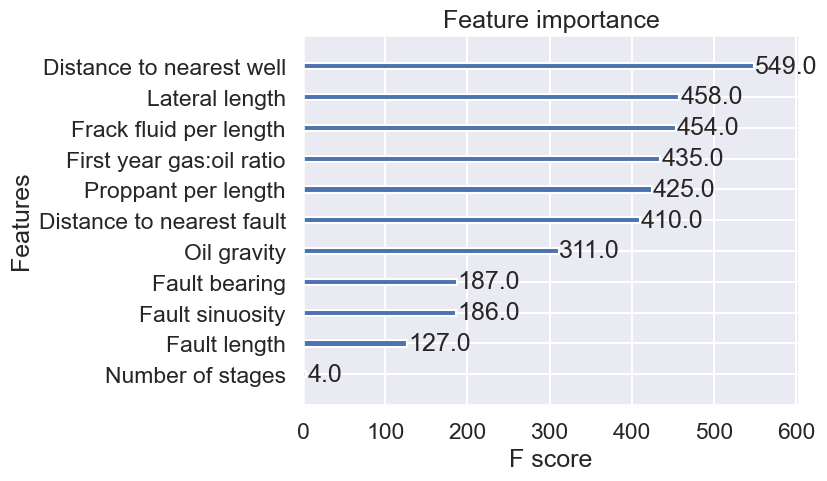

In [19]:
xgb.plot_importance(reg)

In [20]:
test_preds = reg.predict(dtest)
train_preds = reg.predict(dtrain)

print(
    f"MAE train: {mean_absolute_error(train_preds, y_train):.2f}",
)
print(f"MAE test: {mean_absolute_error(test_preds, y_test):.2f}")

print(
    f"R2 train: {np.corrcoef(train_preds, y_train)[0,1] **2:.2f}",
)
print(f"R2 test: {np.corrcoef(test_preds, y_test)[0,1] **2:.2f}")

MAE train: 0.08
MAE test: 0.54
R2 train: 0.99
R2 test: 0.30


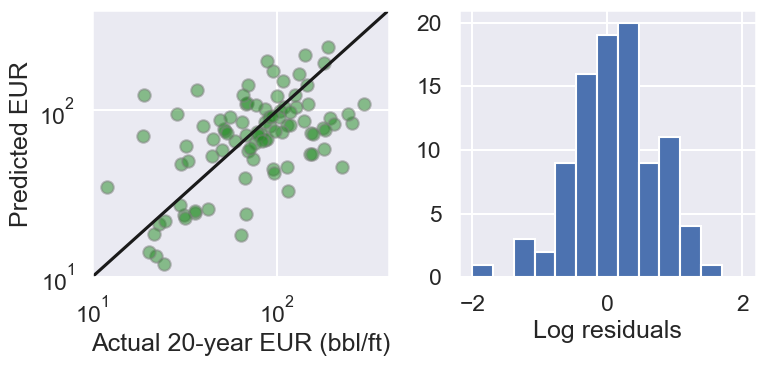

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
lims = [10, 400]
ax1.plot(lims, lims, "k-")
ax1.scatter(
    np.exp(y_test),
    np.exp(test_preds),
    color="forestgreen",
    alpha=0.5,
    edgecolors="gray",
)

ax1.set(
    xlabel="Actual 20-year EUR (bbl/ft)",
    xlim=lims,
    xscale="log",
    ylabel="Predicted EUR",
    ylim=lims,
    yscale="log",
)
# ax2.scatter(np.exp(y_test), y_test - test_preds, color='forestgreen')
# ax2.set(
#     xlabel='Actual 20-year EUR (bbl/ft)',
#     xlim=(0,300),
#     ylabel='Log-residual',
#     ylim=(-2,2),
# )
ax2.hist(y_test - test_preds, bins=np.linspace(-2, 2, 14))
ax2.set(xlabel="Log residuals")
fig.tight_layout()
fig.savefig(fig_dir / "xgboost_fault_comparison.png", dpi=400, bbox_inches="tight")

In [23]:
xpl = SmartExplainer(reg)
xpl.compile(
    x=X_test
)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

# SHAP

In [ ]:
### Fix bug with SHAP
# reg_byte_array = reg.save_raw()#[4:]
# reg.save_raw = lambda: reg_byte_array

In [24]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

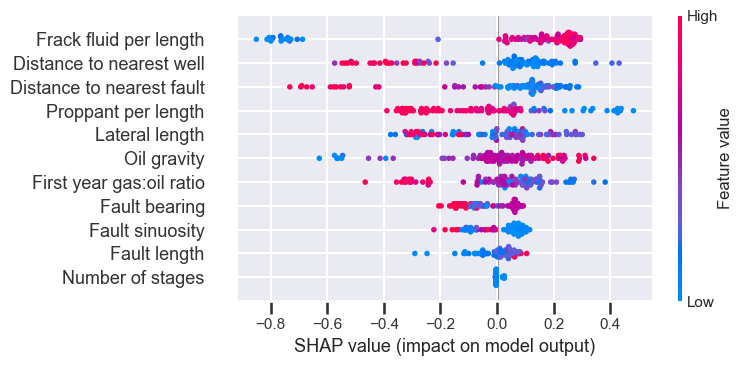

In [25]:
shap.summary_plot(shap_values, X_test, show=False, plot_size=(8, 4))
# plt.savefig(fig_dir / "SHAP_values_faults_xgb.png", dpi=500, bbox_inches="tight")

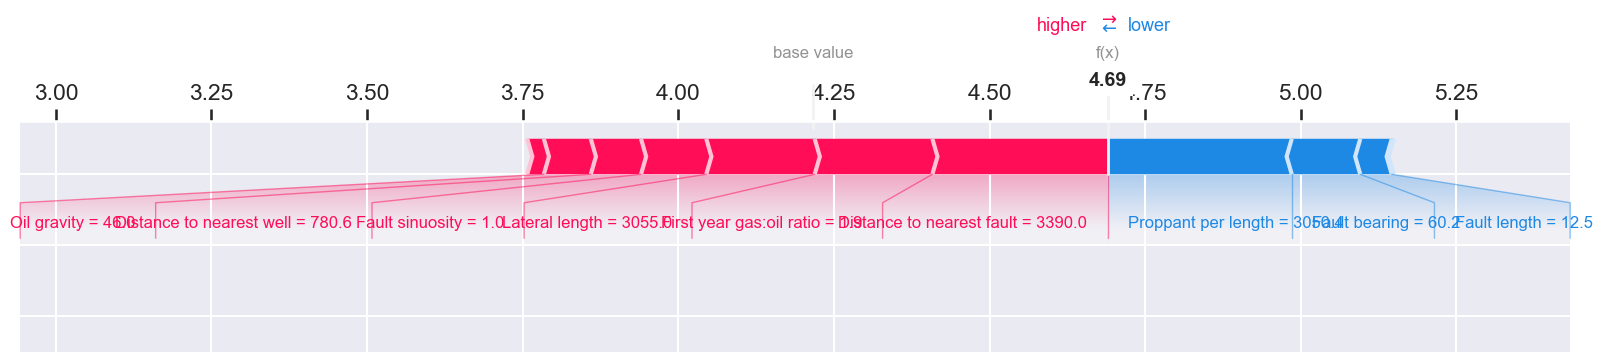

In [26]:
# i = 46
i = 22
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_train.iloc[i, :].apply(lambda x: round(x, 1)),
    matplotlib=True,
)

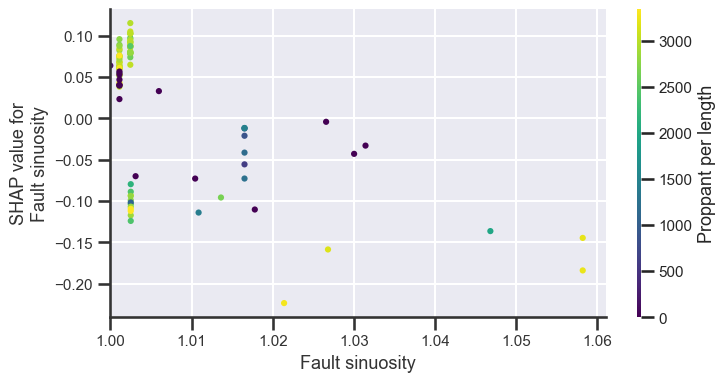

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Fault sinuosity",
    shap_values,
    X_test,
    show=False,
    cmap="viridis",
    dot_size=20,
    ax=ax,
)
ax.set(xlim=(1, None))
# plt.savefig(fig_dir + "SHAP_values_sinuosity_xgb.png", dpi=500, bbox_inches="tight")

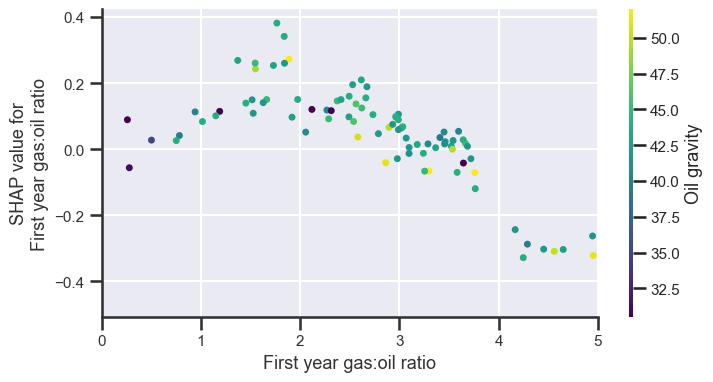

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "First year gas:oil ratio",
    shap_values,
    X_test,
    show=False,
    interaction_index="Oil gravity",
    cmap="viridis",
    dot_size=25,
    ax=ax,
)
ax.set(xlim=(0, 5))
# plt.savefig(fig_dir / "SHAP_values_GOR_xgb.png", dpi=500, bbox_inches="tight")

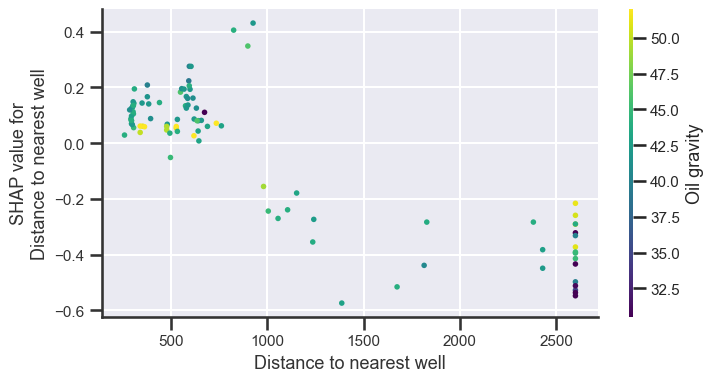

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest well", shap_values, X_test, show=False, cmap="viridis", ax=ax
)
# ax.set(xlim=(0, 5))
# plt.savefig(fig_dir / 'SHAP_values_distance_xgb.png', dpi=500, bbox_inches='tight')

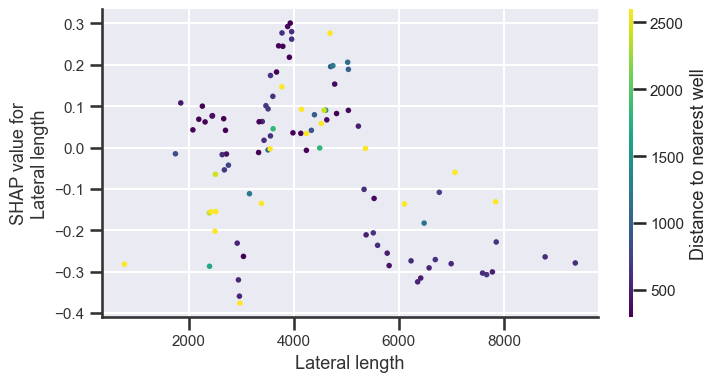

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Lateral length", shap_values, X_test, show=False, cmap="viridis", ax=ax
)
# ax.set(xlim=(0, 5))
# plt.savefig(fig_dir / 'SHAP_values_ll_xgb.png', dpi=500, bbox_inches='tight')

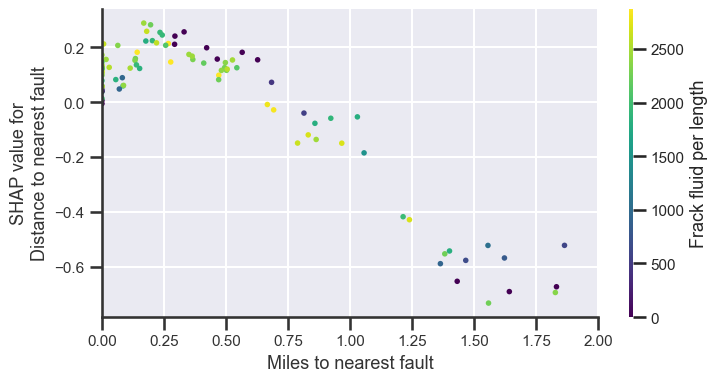

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest fault",
    shap_values,
    X_test.assign(
        **{"Distance to nearest fault": lambda x: x["Distance to nearest fault"] / 5280}
    ),
    show=False,
    cmap="viridis",
    ax=ax,
)
ax.set(xlim=(0, 2), xlabel="Miles to nearest fault")
# plt.savefig(fig_dir / "SHAP_values_Fault distance_xgb.png", dpi=500, bbox_inches="tight")